## About Project

This project aims to build a classification model for sEMG (surface electromyography) signals to recognize hand gestures performed by individuals. The project involves the following steps:

- Data Acquisition: Collecting sEMG signals from 6 participants while performing 6 different hand gestures.

- Preprocessing: Filtering and cleaning the collected sEMG signals to remove any noise or unwanted artifacts.

- Feature Extraction: Extracting relevant features from the preprocessed sEMG signals to be used for classification.

- Classification: Developing and comparing different machine learning models for classifying the hand gestures based on the extracted features.

- Model Evaluation: Evaluating the performance of the developed models using metrics such as accuracy, precision, recall, and F1 score.

The goal of this project is to create a reliable and accurate classification model for sEMG signals that can be used in real-world applications such as prosthetic control, human-robot interaction, and virtual reality. The project will explore different outlier handling techniques and classification models to determine the best approach for achieving high accuracy in classifying the hand gestures.

## Importing Necessary Librarys

Various libraries are imported for different purposes, such as data handling and manipulation, signal processing, machine learning, data visualization, and statistical analysis.

In [124]:
import pandas as pd                # For data handling and manipulation
import os                          # For working with files and directories
import numpy as np                 # For numerical operations
from scipy.signal import butter, filtfilt, lfilter, hann, welch, stft # For signal processing
import matplotlib.pyplot as plt    # For data visualization
import seaborn as sns              # For statistical data visualization
from sklearn.model_selection import train_test_split    # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler       # For feature scaling
from scipy.stats import mstats, zscore, yeojohnson, boxcox, anderson # For statistical analysis and transformations
from sklearn.neighbors import KNeighborsClassifier      # For KNN classification
from sklearn.svm import SVC                             # For SVM classification
from sklearn import svm                                 # For SVM classification
from sklearn.model_selection import KFold   # For KFold classification
from sklearn.model_selection import cross_val_score  # For KFold score
from sklearn.model_selection import cross_val_predict
from scipy.stats import mode
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # For evaluating model performance
import matplotlib.font_manager as font_manager          # For setting custom fonts in matplotlib plots
from sklearn.ensemble import RandomForestClassifier    # For random forest classification
from xgboost import XGBClassifier                       # For XGBoost classification
from sklearn.linear_model import LogisticRegression    # For logistic regression classification
from sklearn.preprocessing import LabelEncoder         # For encoding categorical labels
import pywt                                            # For discrete wavelet transform analysis
import warnings                                        # For suppressing warnings

## Palette Set for Future Data Viusalizations

A custom color palette is defined using HEX color codes. This palette will be used for data visualizations throughout the project. Custom font settings are also defined for the data visualizations.

In [8]:
# Font
font_times = font_manager.FontProperties(family='Times New Roman', size=12)
font_times_bold = font_manager.FontProperties(family='Times New Roman', size=12, weight='bold')

# Color
colors = ['#000050', '#D22730', '#00C2E7', '#EB6450', '#F2A216', '#23374E','#FF5900', '#0072CF', '#8EACE1', '#AC55C0',
         '#364D75']
sns.set_palette(sns.color_palette(colors))

## Gesture Codes and Pre-Processing Files

his block contains the definition of gesture codes and pre-processing functions for the sEMG gesture classification project.

1. gesture_codes: A dictionary mapping codes for each gesture to their corresponding names.
2. process_file: A function that processes the sEMG signal data in a file by reading the file into a pandas DataFrame, converting columns to numeric data types, adjusting time values if necessary, performing baseline correction, and adding columns for participant name and gesture name.
3. process_directory: A function that processes all CSV files in a directory using the process_file function and returns the concatenated DataFrame for all files in the directory.
4. all_dfs: A list created by calling the process_directory function for each participant directory. The resulting DataFrames are concatenated into a single DataFrame called df, which contains columns for time, channel 1, channel 2, participant name, and gesture name. The df DataFrame is returned after dropping the first row and converting the Channel 1, Channel 2, and Time(s) columns to numeric data types.

In [30]:
gesture_codes = {
    'a': 'Rest',
    'b': 'Fist',
    'c': 'Hand outward',
    'd': 'Hand upward',
    'e': 'Wrist inward',
    'f': 'Hand inward'
}

In [31]:
#Participant data
directories = [ '../data/dataahmet', '../data/datacem','../data/dataege',
              '../data/datagorkem', '../data/datamerve', '../data/datamustafa']

In [33]:
def process_file(filepath, participant_name):
    gesture = os.path.basename(filepath).split('-')[1].split(' ')[0]
    
    # Check if the gesture is in the gesture_codes dictionary
    if gesture not in gesture_codes:
        return None

    gesture_name = gesture_codes[gesture]
    
    df = pd.read_csv(filepath, skiprows=10, names=['Time(s)', 'Channel 1', 'Channel 2'])
    
    # Convert the Time(s), Channel 1, and Channel 2 columns to numeric
    df['Time(s)'] = pd.to_numeric(df['Time(s)'], errors='coerce')
    df['Channel 1'] = pd.to_numeric(df['Channel 1'], errors='coerce')
    df['Channel 2'] = pd.to_numeric(df['Channel 2'], errors='coerce')
    
    # Check if the minimum time value is negative and adjust if necessary
    min_time = df['Time(s)'].min()
    if min_time < 0:
        df['Time(s)'] = df['Time(s)'] - min_time

    # Perform baseline correction after converting columns to numeric
    df['Channel 1'] = df['Channel 1'] - df['Channel 1'].mean()
    df['Channel 2'] = df['Channel 2'] - df['Channel 2'].mean()
    
    df['ParticipantName'] = participant_name
    df['GestureName'] = gesture_name
    
    return df



# Function to process a directory containing csv files
def process_directory(directory):
    participant_name = os.path.basename(directory)
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
    
    dfs = [process_file(f, participant_name) for f in all_files]
    return pd.concat(dfs)


# Process each directory and merge into a single DataFrame
all_dfs = [process_directory(d) for d in directories]
df = pd.concat(all_dfs).reset_index(drop=True)
df.drop(index=0, inplace=True)
# Convert the Channel 1 and Channel 2 columns to numeric
df['Channel 1'] = pd.to_numeric(df['Channel 1'], errors='coerce')
df['Channel 2'] = pd.to_numeric(df['Channel 2'], errors='coerce')
df['Time(s)'] = pd.to_numeric(df['Time(s)'], errors='coerce')

In [34]:
df.head()

Time(s)  Channel 1  Channel 2 ParticipantName   GestureName
1  0.00000   0.008292  -0.011304       dataahmet  Hand outward
2  0.00025   0.008631  -0.011304       dataahmet  Hand outward
3  0.00050   0.008969  -0.010971       dataahmet  Hand outward
4  0.00075   0.009308  -0.010638       dataahmet  Hand outward
5  0.00100   0.009647  -0.010638       dataahmet  Hand outward

## Normalizing Data

This block performs normalization of the sEMG signal data by scaling the Channel 1 and Channel 2 values based on the global maximum and minimum values of each channel. Normalization is an important step in machine learning, as it helps to improve the performance of the models by scaling the data to a consistent range.

1. A copy of the original DataFrame is created using the df.copy() method to avoid modifying the original data. This copy is stored in the df_original DataFrame.

2. The normalize function is defined, which takes a DataFrame as input and performs normalization on the Channel 1 and Channel 2 columns. The global minimum and maximum values for each channel are found using the min() and max() methods.

3. The Channel 1 and Channel 2 data in the input DataFrame is then scaled by subtracting the global minimum value and dividing by the range (global maximum - global minimum) for each channel.

4. The normalized DataFrame is returned, and the normalize function is applied to the original DataFrame df. The resulting DataFrame with normalized data is stored in df_normalized.

In [39]:
all_dfs = [process_directory(d) for d in directories]
df = pd.concat(all_dfs).reset_index(drop=True)
df.drop(index=0, inplace=True)
# Convert the Channel 1 and Channel 2 columns to numeric
df['Channel 1'] = pd.to_numeric(df['Channel 1'], errors='coerce')
df['Channel 2'] = pd.to_numeric(df['Channel 2'], errors='coerce')
df['Time(s)'] = pd.to_numeric(df['Time(s)'], errors='coerce')

# Create a copy of the original DataFrame
df_original = df.copy()


def normalize(df):
    # Find the global maximum and minimum values for Channel 1 and Channel 2
    global_min_ch1 = df['Channel 1'].min()
    global_max_ch1 = df['Channel 1'].max()
    global_min_ch2 = df['Channel 2'].min()
    global_max_ch2 = df['Channel 2'].max()

    # Normalize Channel 1 and Channel 2 data based on the global maximum and minimum values
    df['Channel 1'] = (df['Channel 1'] - global_min_ch1) / (global_max_ch1 - global_min_ch1)
    df['Channel 2'] = (df['Channel 2'] - global_min_ch2) / (global_max_ch2 - global_min_ch2)

    return df

# Normalize the data
df_normalized = normalize(df.copy())

In [40]:
df_normalized.head()

Time(s)  Channel 1  Channel 2 ParticipantName   GestureName
1  0.00000   0.554838   0.646266       dataahmet  Hand outward
2  0.00025   0.555618   0.646266       dataahmet  Hand outward
3  0.00050   0.556398   0.647133       dataahmet  Hand outward
4  0.00075   0.557177   0.648001       dataahmet  Hand outward
5  0.00100   0.557957   0.648001       dataahmet  Hand outward

#### Shape of the dataset

In [153]:
df_normalized.shape[0]

288000

### Viusalization: Compare Normalized and Non-Normalized Data

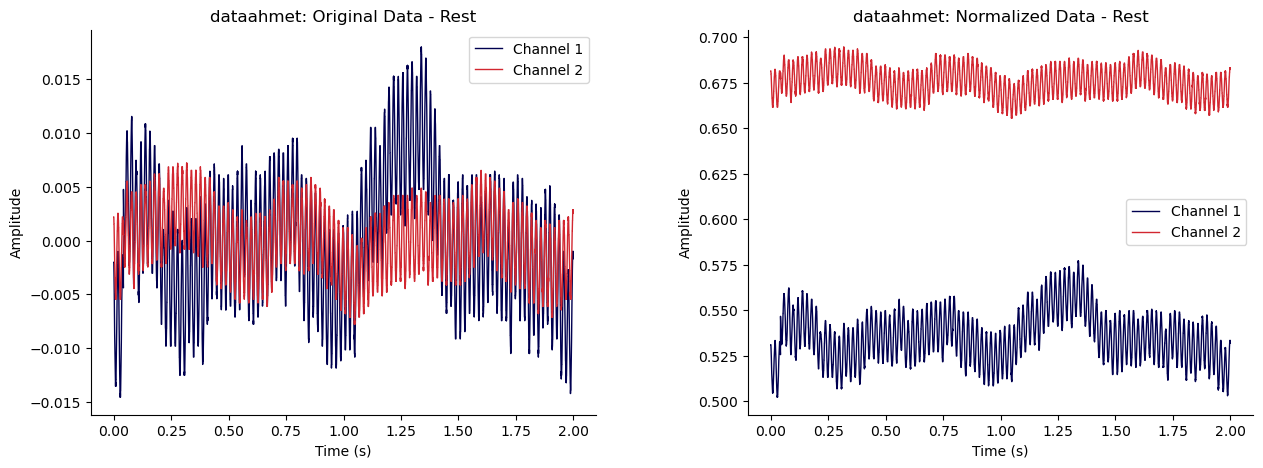

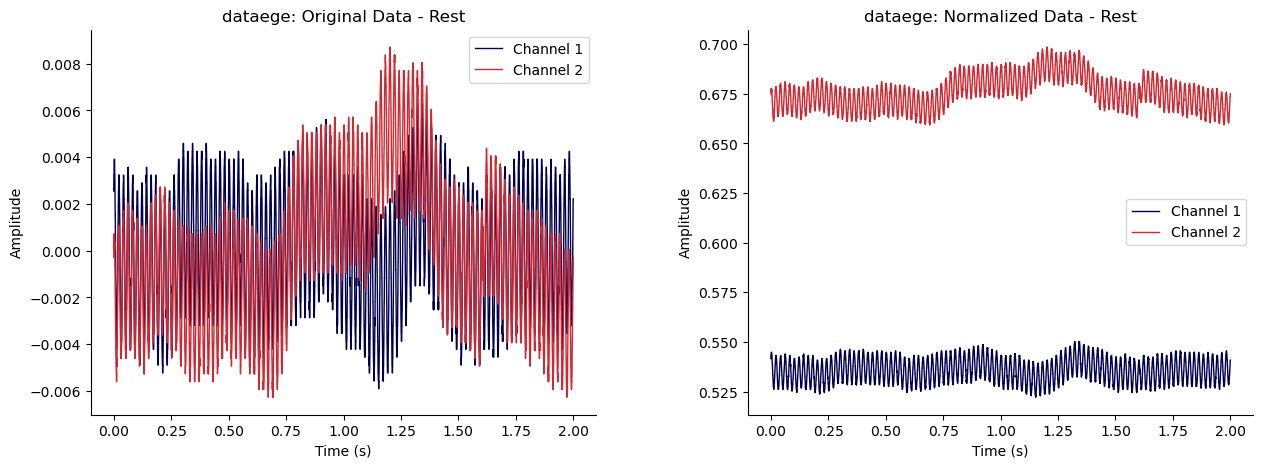

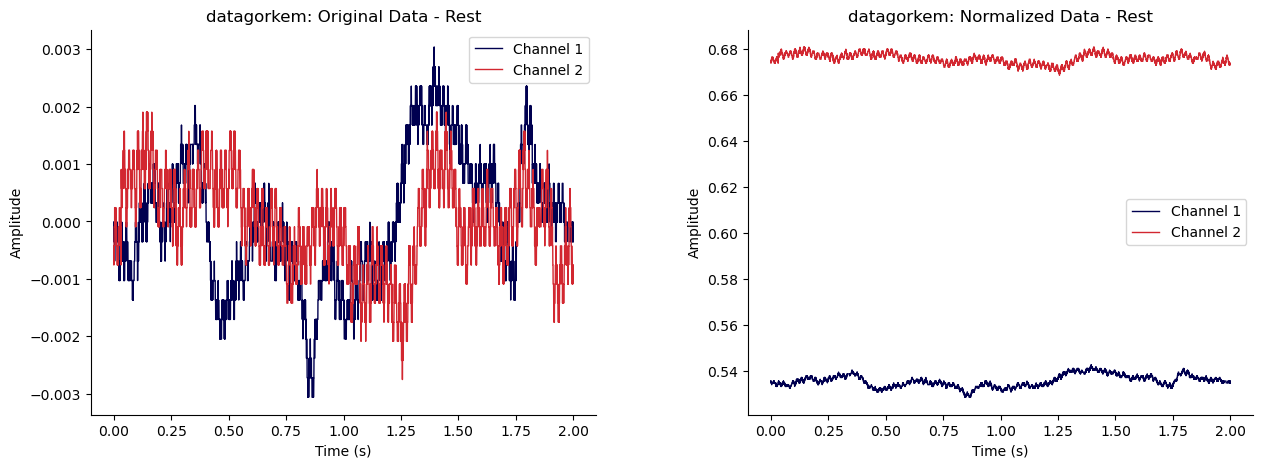

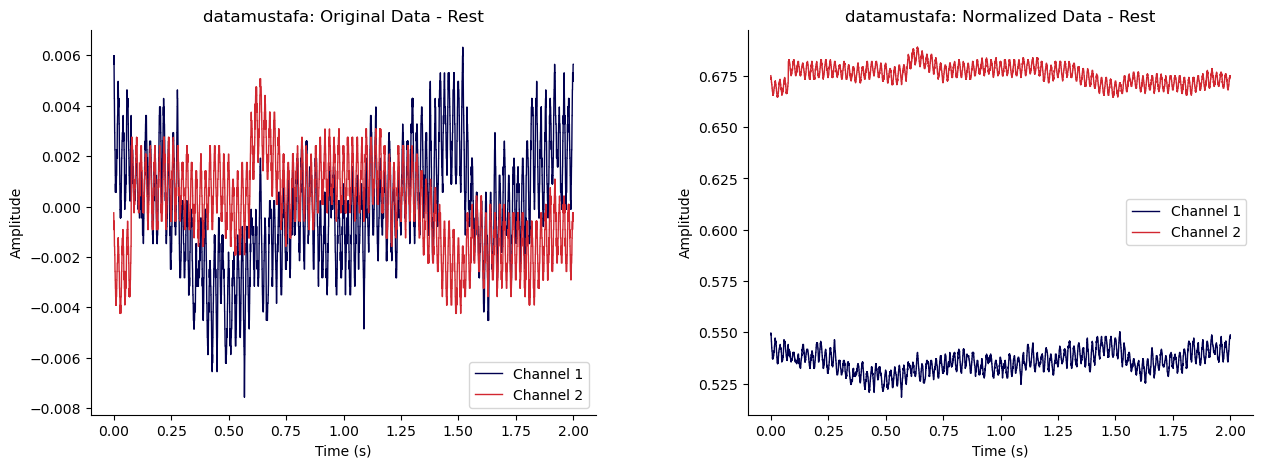

In [80]:
def plot_signal(df, gesture, participant, title, color=colors, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.plot(df['Time(s)'], df['Channel 1'], label='Channel 1', linewidth=1, color=color[0])
    ax.plot(df['Time(s)'], df['Channel 2'], label='Channel 2', linewidth=1, color=color[1])
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    ax.legend()

    sns.despine(ax=ax)

# Define the list of participants
participants = ['dataahmet', 'dataege', 'datagorkem', 'datamustafa']

# Define the gesture to plot
selected_gesture = 'Rest'

# Loop through all participants and plot the original and normalized data for the selected gesture
for participant in participants:
    # Select the original data and the normalized data
    original_data = df_original[(df_original['GestureName'] == selected_gesture) & (df_original['ParticipantName'] == participant)]
    normalized_data = df_normalized[(df_normalized['GestureName'] == selected_gesture) & (df_normalized['ParticipantName'] == participant)]

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plot the original data
    plot_signal(original_data, selected_gesture, participant,
                title=f'{participant}: Original Data - {selected_gesture}', ax=axes[0])

    # Plot the normalized data
    plot_signal(normalized_data, selected_gesture, participant,
                title=f'{participant}: Normalized Data - {selected_gesture}', ax=axes[1])

    # Adjust the space between the subplots
    plt.subplots_adjust(wspace=0.3)

    # Show the plots
    plt.show()


## Handling Outliers

In this block, we first prepared the data by dropping rows with NaN values in Channel 1 and Channel 2. We then applied various outlier handling and data transformation techniques to the df_normalized DataFrame. These techniques include:

1. Interquartile Range (IQR): We calculated the IQR for each channel and removed the outliers by keeping only the data points within 1.5 * IQR from the first and third quartiles.
2. Z-score Standardization: We standardized the data by applying Z-score normalization to each channel, resulting in a mean of 0 and a standard deviation of 1.
3. Yeo-Johnson Transformation: We applied the Yeo-Johnson transformation to each channel to make the data more normally distributed.
4. Winsorization: We applied Winsorization to each channel, replacing the extreme values with specified percentiles. In this case, we used 1% for both lower and upper limits.
5. Hampel Filter: We applied the Hampel filter to each channel, which is a robust outlier detection technique based on the median and the Median Absolute Deviation (MAD).
6. IQR & Z-Score: We combined the IQR and Z-score techniques by first applying the IQR method to remove outliers and then standardizing the data using Z-score normalization

In [66]:
df_normalized.dropna(subset=['Channel 1', 'Channel 2'], inplace=True)

def iqr_outliers(df):
    # Calculate IQR for Channel 1 and Channel 2
    Q1_ch1 = df['Channel 1'].quantile(0.25)
    Q3_ch1 = df['Channel 1'].quantile(0.75)
    IQR_ch1 = Q3_ch1 - Q1_ch1

    Q1_ch2 = df['Channel 2'].quantile(0.25)
    Q3_ch2 = df['Channel 2'].quantile(0.75)
    IQR_ch2 = Q3_ch2 - Q1_ch2

    # Apply the IQR method to remove the outliers
    df = df[((df['Channel 1'] >= (Q1_ch1 - 1.5 * IQR_ch1)) & (df['Channel 1'] <= (Q3_ch1 + 1.5 * IQR_ch1))) &
            ((df['Channel 2'] >= (Q1_ch2 - 1.5 * IQR_ch2)) & (df['Channel 2'] <= (Q3_ch2 + 1.5 * IQR_ch2)))]

    return df

def zscore_standardization(df):
    df['Channel 1'] = zscore(df['Channel 1'])
    df['Channel 2'] = zscore(df['Channel 2'])
    return df

def yeojohnson_transformation(df):
    df['Channel 1'], _ = yeojohnson(df['Channel 1'])
    df['Channel 2'], _ = yeojohnson(df['Channel 2'])
    return df


def winsorize_data(df, limits=[0.01, 0.01]):
    df['Channel 1'] = mstats.winsorize(df['Channel 1'], limits=limits)
    df['Channel 2'] = mstats.winsorize(df['Channel 2'], limits=limits)
    return df

def hampel_filter(data, window_size=7, num_dev=3):
    new_data = data.reset_index(drop=True).values
    L = len(new_data)
    new_data = np.concatenate([new_data[window_size-1:0:-1], new_data, new_data[-2:-window_size-1:-1]])
    filtered_data = np.zeros_like(new_data)
    for i in range(L):
        idx = np.arange(i, i + window_size)
        x0 = np.median(new_data[idx])
        S0 = 1.4826 * np.median(np.abs(new_data[idx] - x0))
        if np.abs(new_data[idx[-1]] - x0) > num_dev * S0:
            filtered_data[i] = x0
        else:
            filtered_data[i] = new_data[idx[-1]]
    return filtered_data[window_size-1:-window_size+1]

def apply_hampel_filter(df):
    df['Channel 1'] = hampel_filter(df['Channel 1'])
    df['Channel 2'] = hampel_filter(df['Channel 2'])
    return df


df_iqr = iqr_outliers(df_normalized.copy())
df_zscore = zscore_standardization(df_normalized.copy())
df_yeojohnson = yeojohnson_transformation(df_normalized.copy())
df_winsorized = winsorize_data(df_normalized.copy())
df_hampel = apply_hampel_filter(df_normalized.copy())
df_iqr_zscore = zscore_standardization(df_iqr.copy())

In [74]:
df_yeojohnson.head()

Time(s)  Channel 1  Channel 2 ParticipantName   GestureName
1  0.00000   0.694568   2.135330       dataahmet  Hand outward
2  0.00025   0.695739   2.135330       dataahmet  Hand outward
3  0.00050   0.696909   2.141366       dataahmet  Hand outward
4  0.00075   0.698081   2.147414       dataahmet  Hand outward
5  0.00100   0.699253   2.147414       dataahmet  Hand outward

<b>plot_comparison_gesture</b> to visualize the comparison of these outlier handling techniques for each gesture. The function creates a 2x5 grid of histograms for both Channel 1 and Channel 2, showing the distribution of each channel after applying the outlier handling techniques. In this example, we showed the comparison for the base case<b>'Rest'</b> gesture.

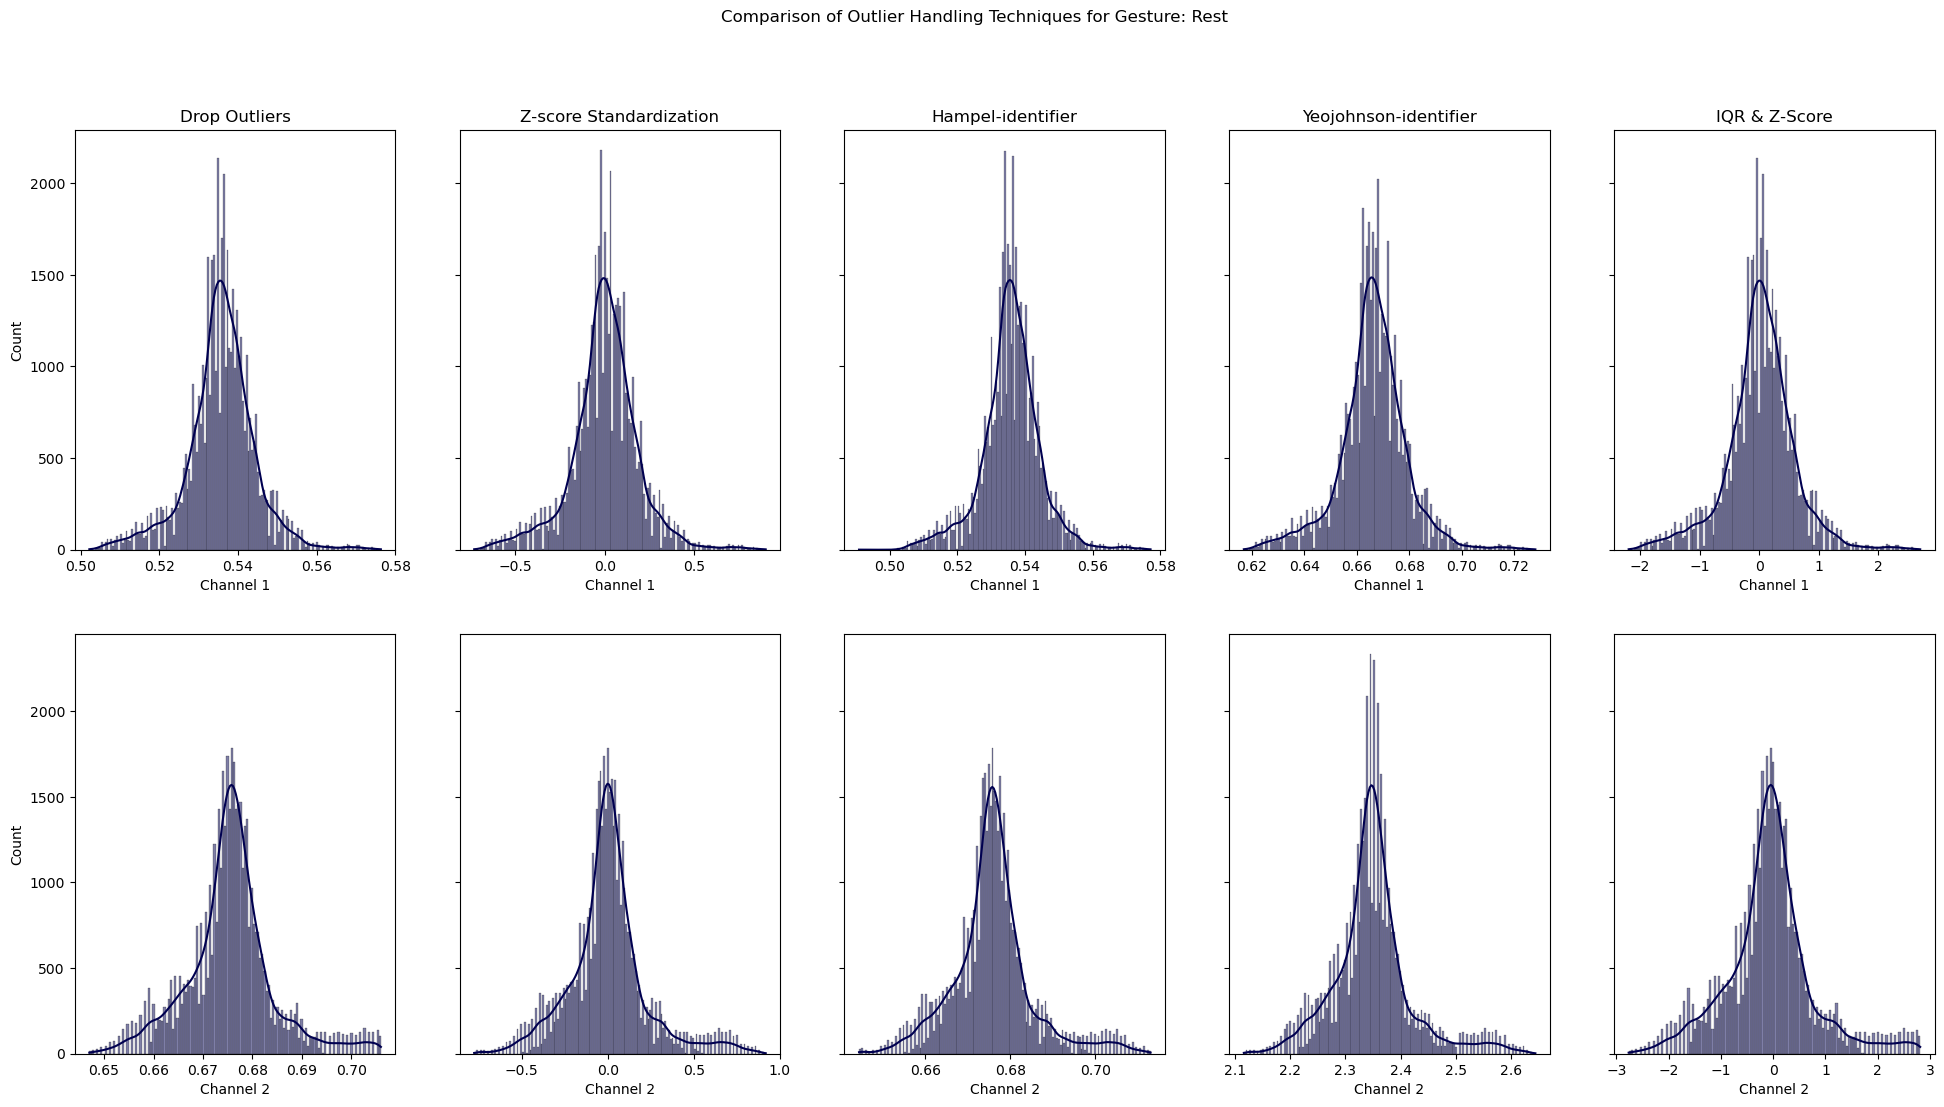

In [78]:
def plot_comparison_gesture(gesture_name):
    # Select the rows corresponding to the current gesture from each DataFrame
    df_iqr_gesture = df_iqr[df_iqr['GestureName'] == gesture_name]
    df_zscore_gesture = df_zscore[df_zscore['GestureName'] == gesture_name]
    df_yeojohnson_gesture = df_yeojohnson[df_yeojohnson['GestureName'] == gesture_name]
    df_hampel_gesture = df_hampel[df_hampel['GestureName'] == gesture_name]
    df_iqr_zscore_gesture = df_iqr_zscore[df_iqr_zscore['GestureName'] == gesture_name]

    fig, axes = plt.subplots(2, 5, figsize=(24, 12), sharey='row')
    sns.histplot(df_iqr_gesture['Channel 1'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Drop Outliers')
    sns.histplot(df_zscore_gesture['Channel 1'], kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Z-score Standardization')
    sns.histplot(df_hampel_gesture['Channel 1'], kde=True, ax=axes[0, 2])
    axes[0, 2].set_title('Hampel-identifier')
    sns.histplot(df_yeojohnson_gesture['Channel 1'], kde=True, ax=axes[0, 3])
    axes[0, 3].set_title('Yeojohnson-identifier')
    sns.histplot(df_iqr_zscore_gesture['Channel 1'], kde=True, ax=axes[0, 4])
    axes[0, 4].set_title('IQR & Z-Score')

    sns.histplot(df_iqr_gesture['Channel 2'], kde=True, ax=axes[1, 0])
    sns.histplot(df_zscore_gesture['Channel 2'], kde=True, ax=axes[1, 1])
    sns.histplot(df_hampel_gesture['Channel 2'], kde=True, ax=axes[1, 2])
    sns.histplot(df_yeojohnson_gesture['Channel 2'], kde=True, ax=axes[1, 3])
    sns.histplot(df_iqr_zscore_gesture['Channel 2'], kde=True, ax=axes[1, 4])

    fig.suptitle(f'Comparison of Outlier Handling Techniques for Gesture: {gesture_name}')
    plt.show()
    
plot_comparison_gesture('Rest')

## Power Spectrum Density for Each Gesture

Nyquist: 
Sampling rate = 1 / 0.00025 = 4000 samples per second


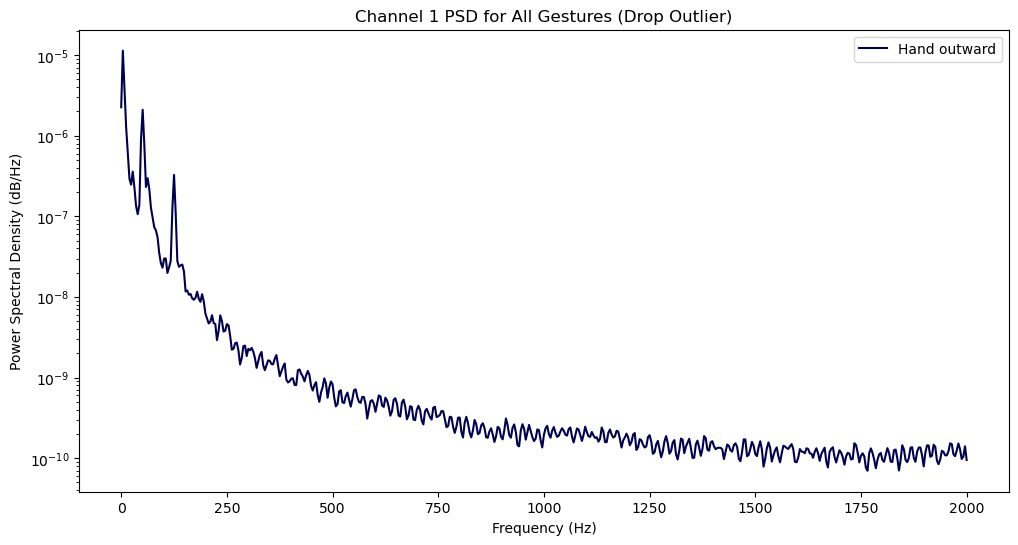

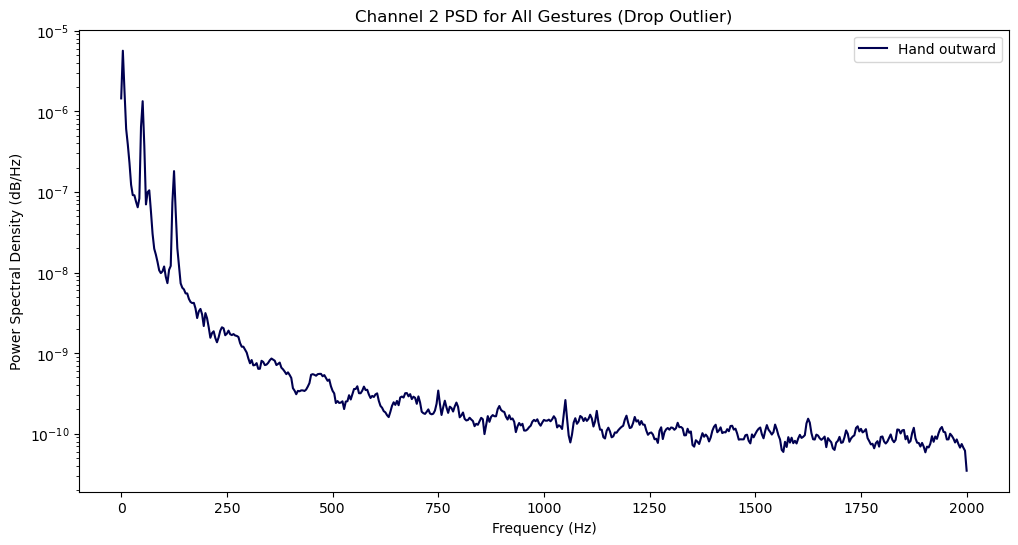

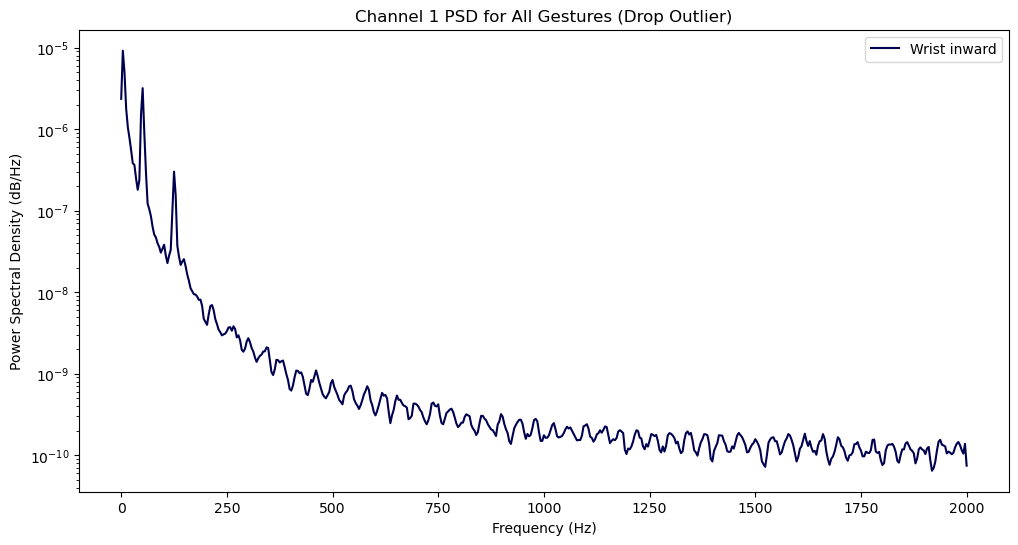

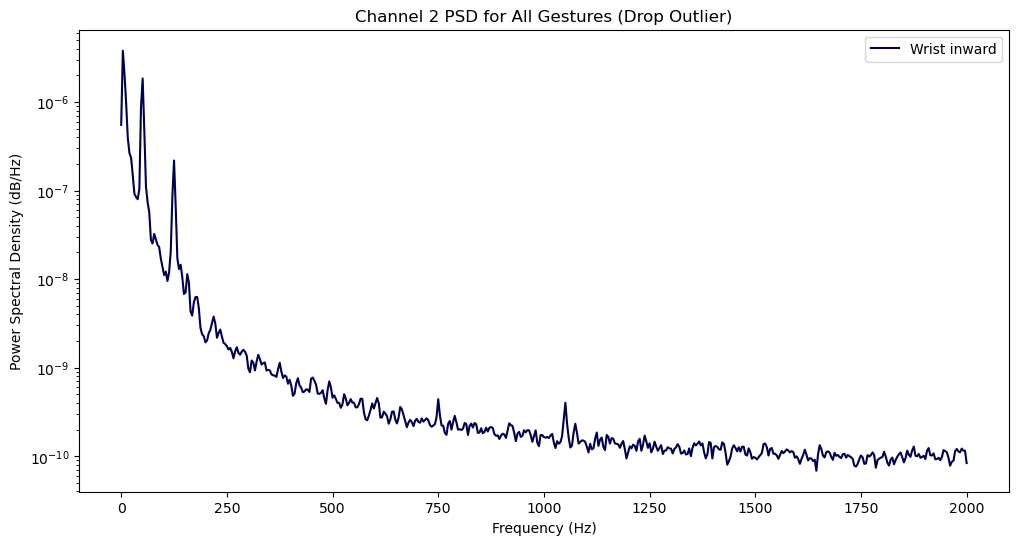

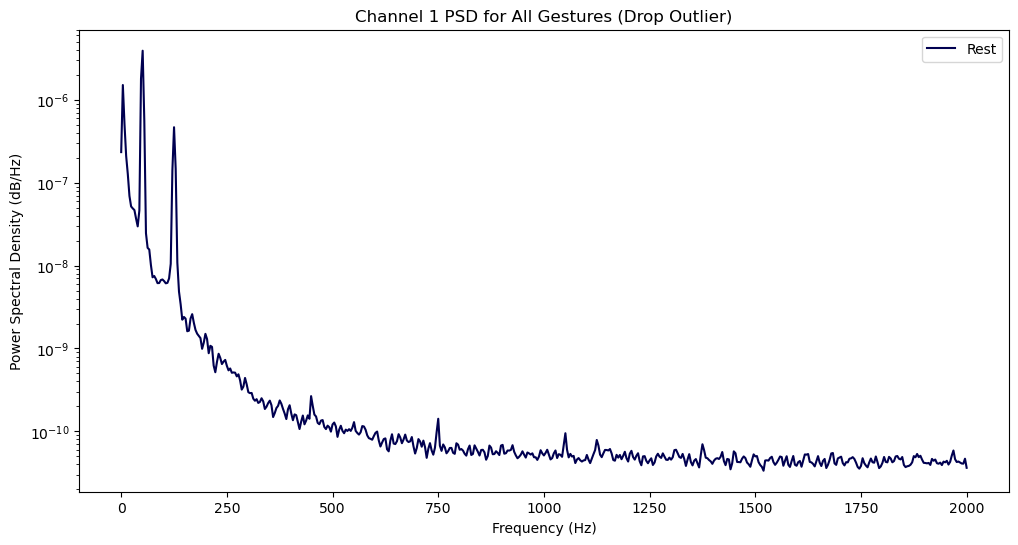

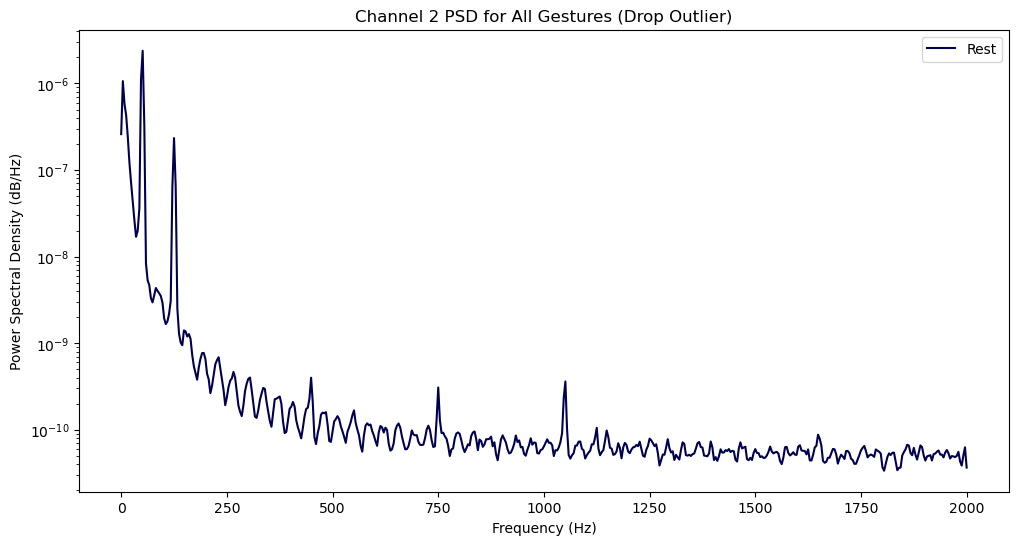

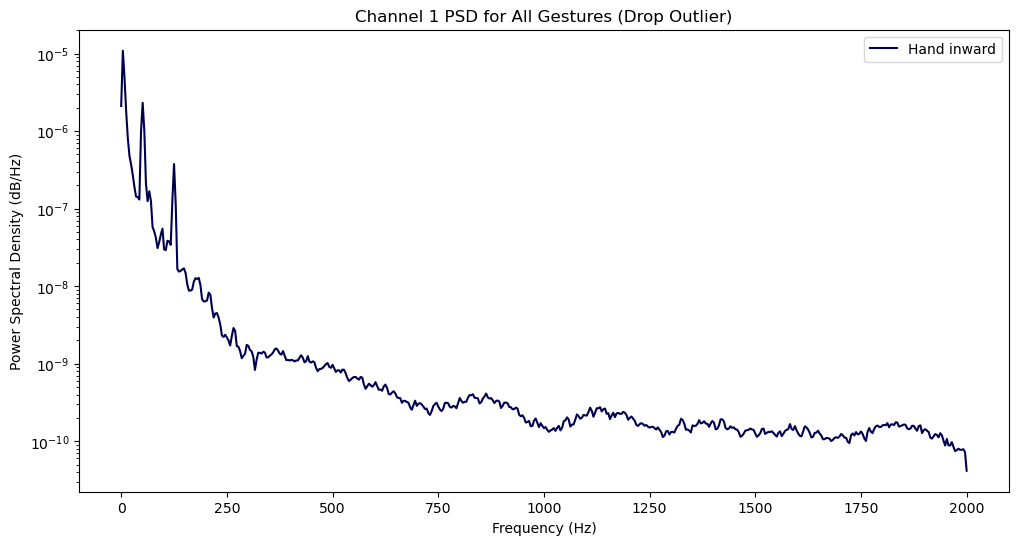

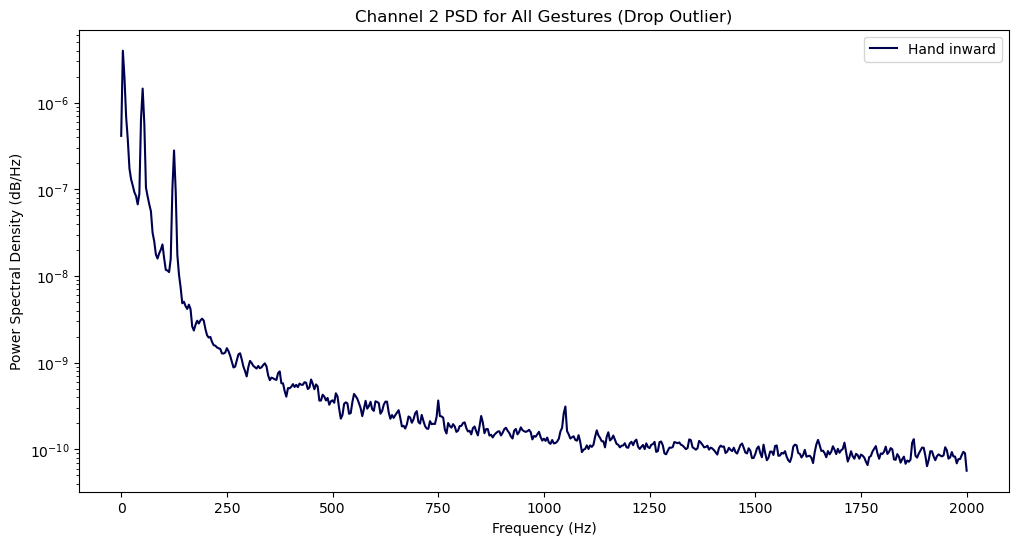

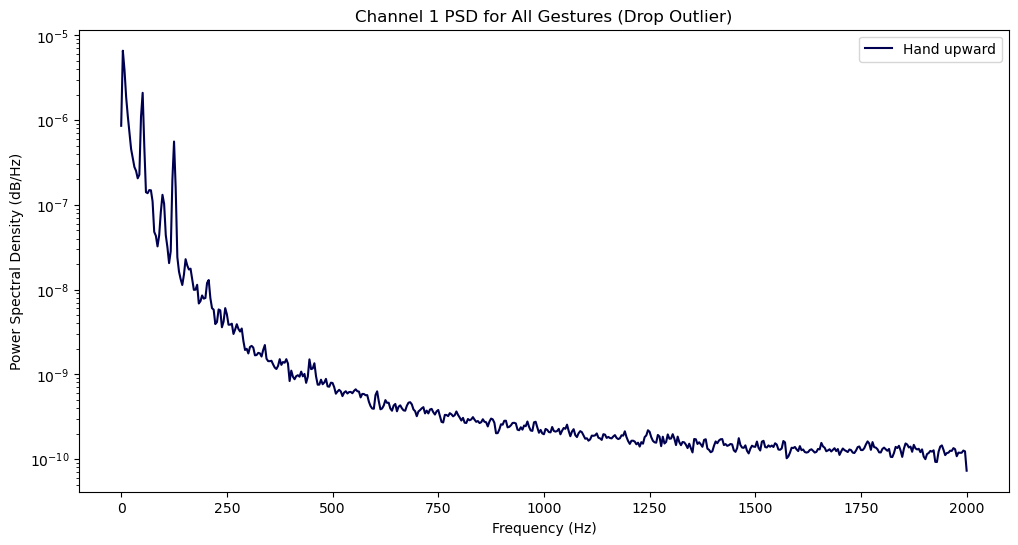

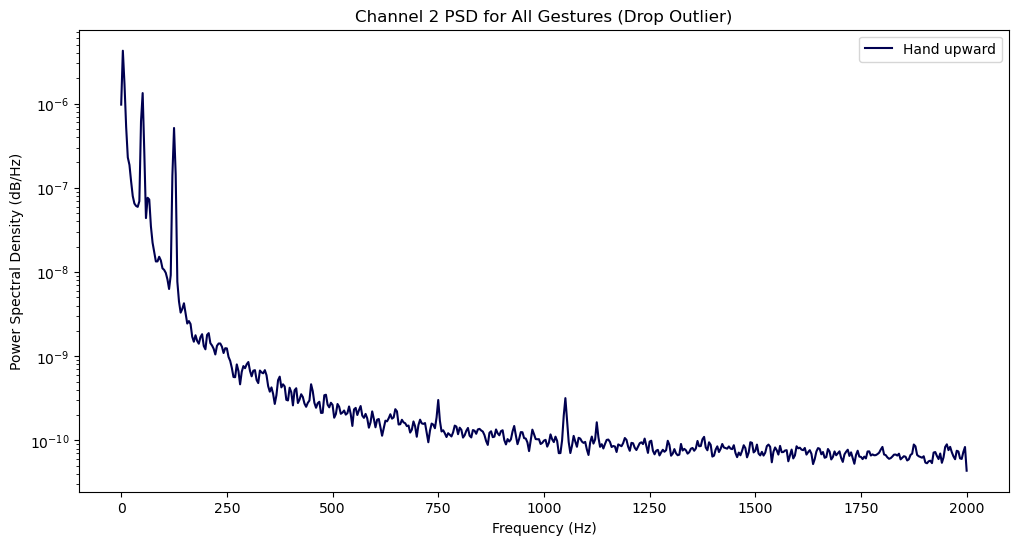

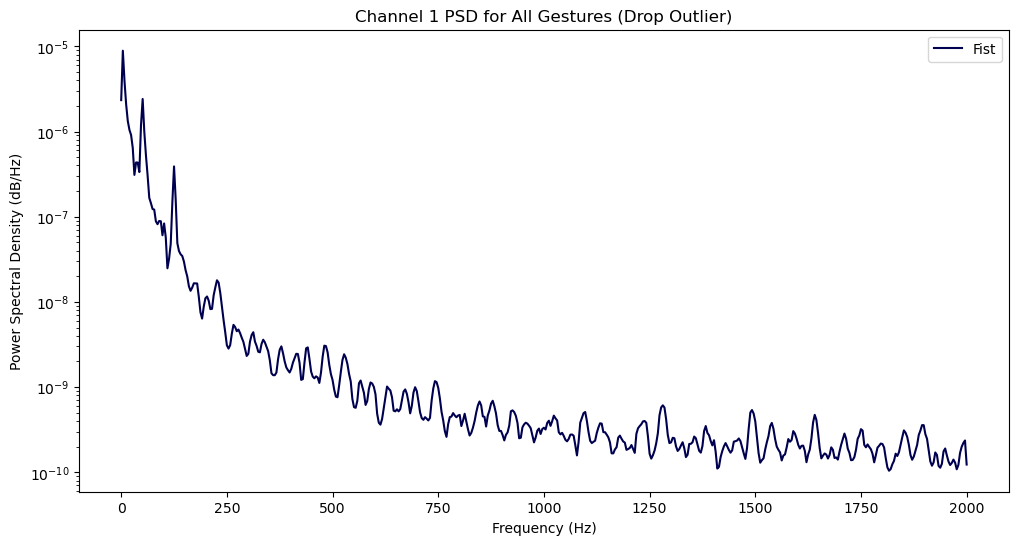

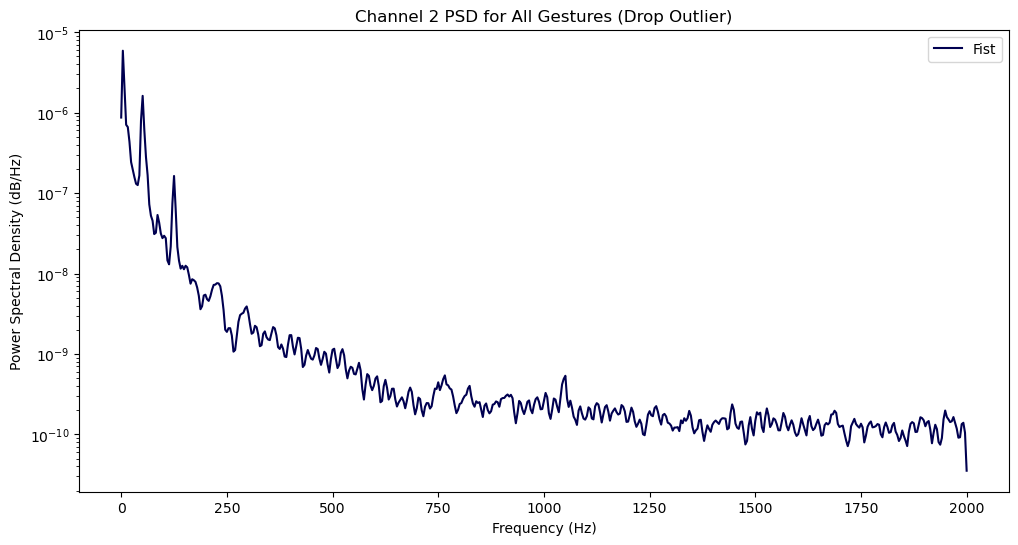

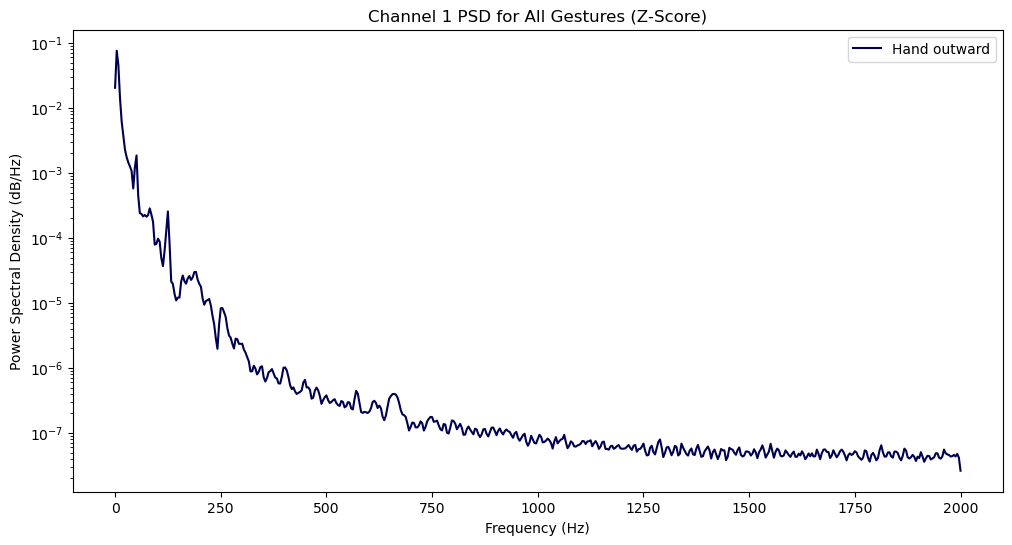

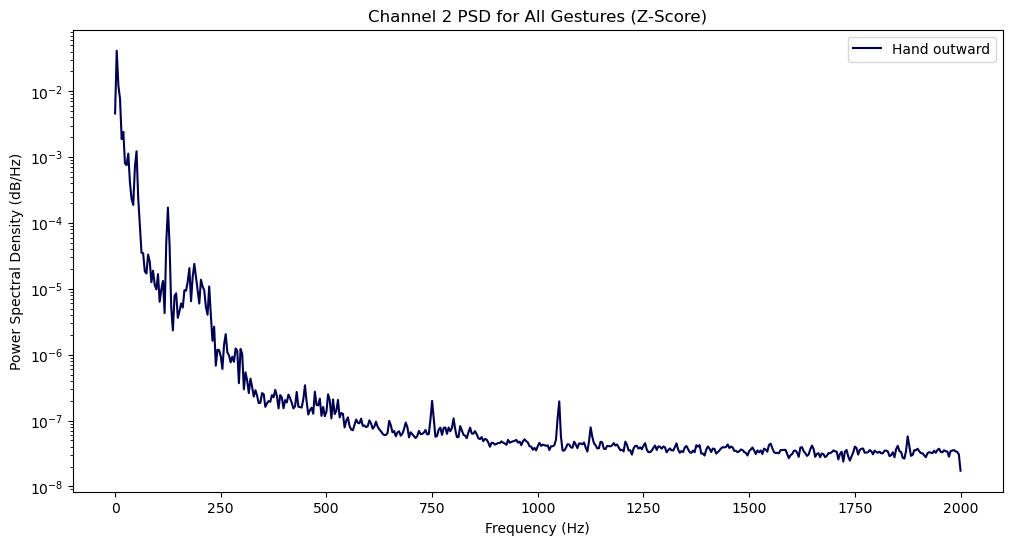

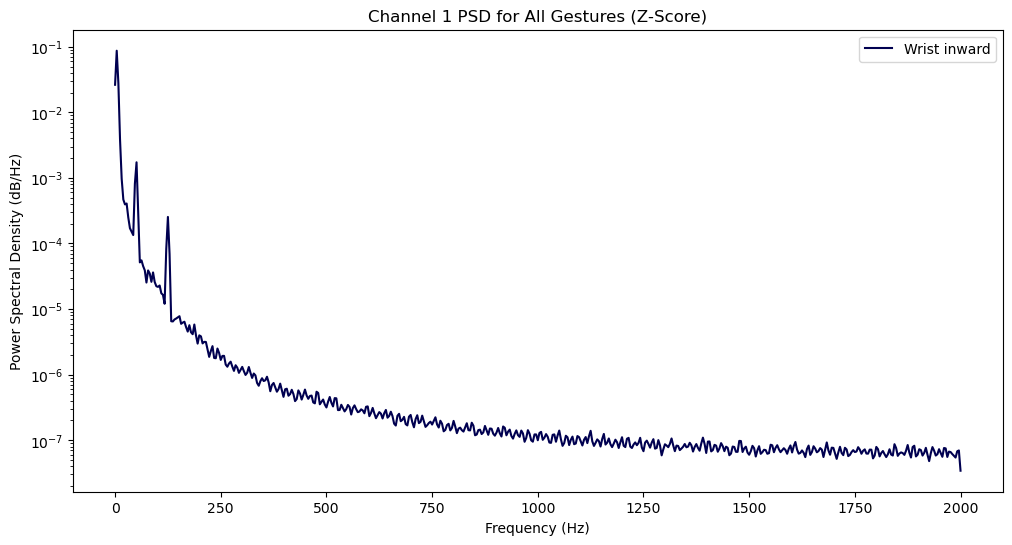

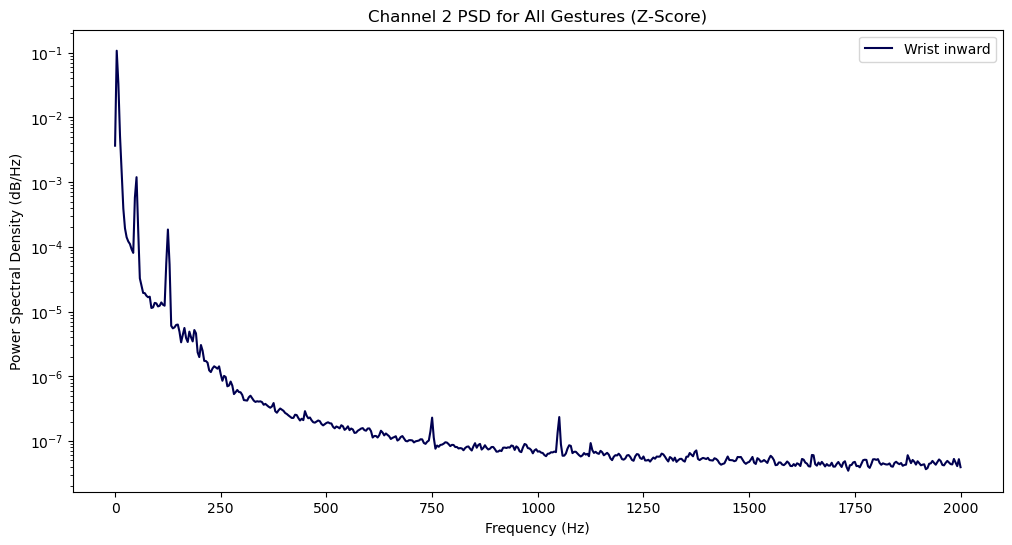

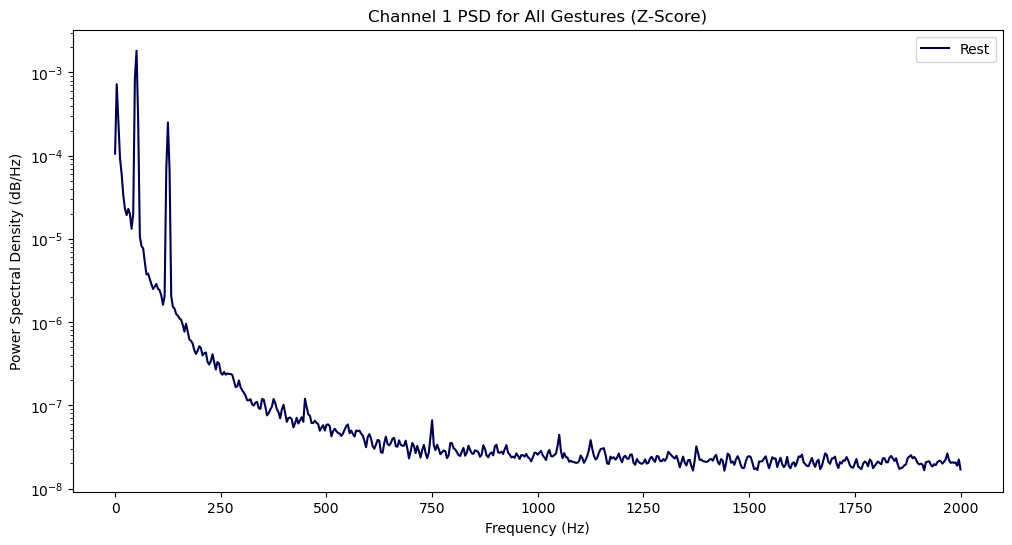

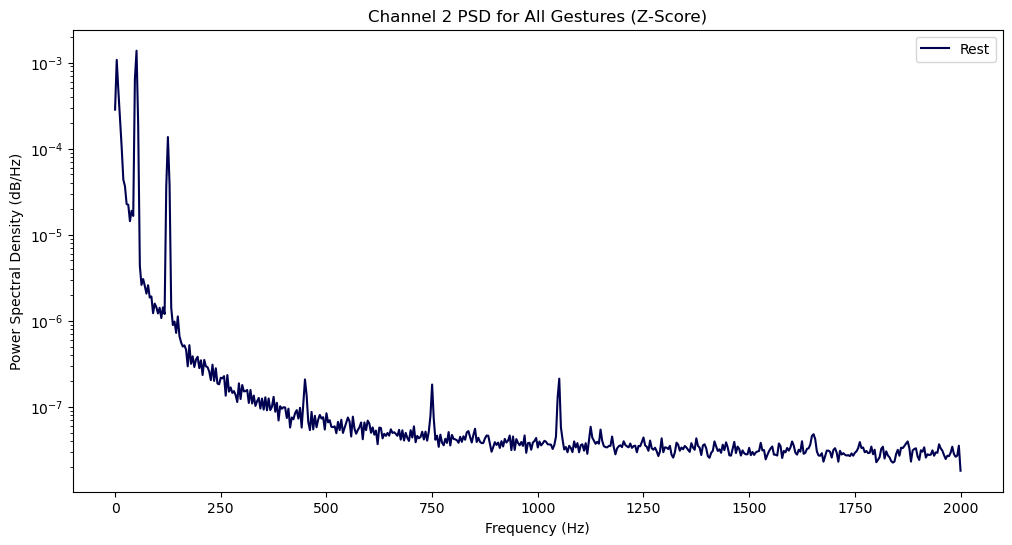

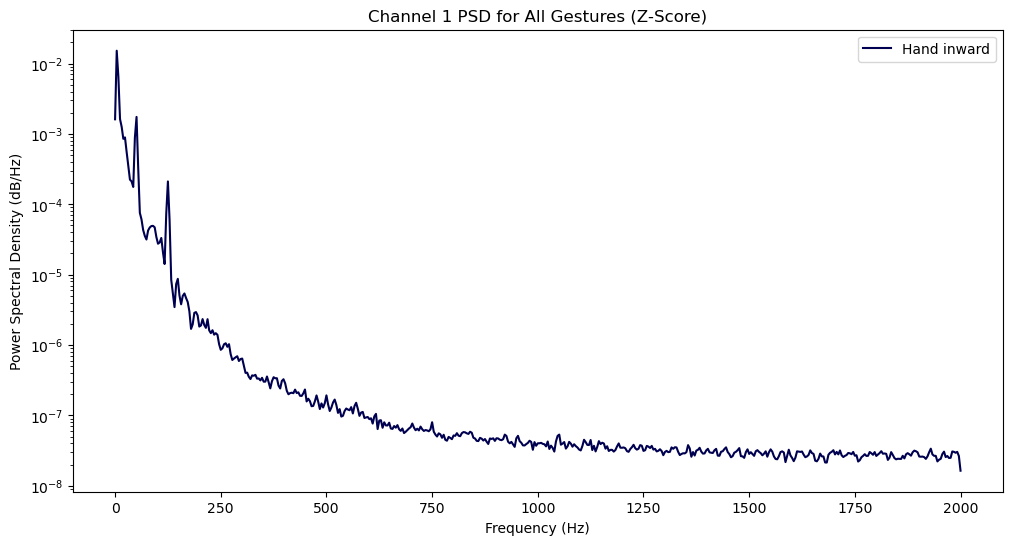

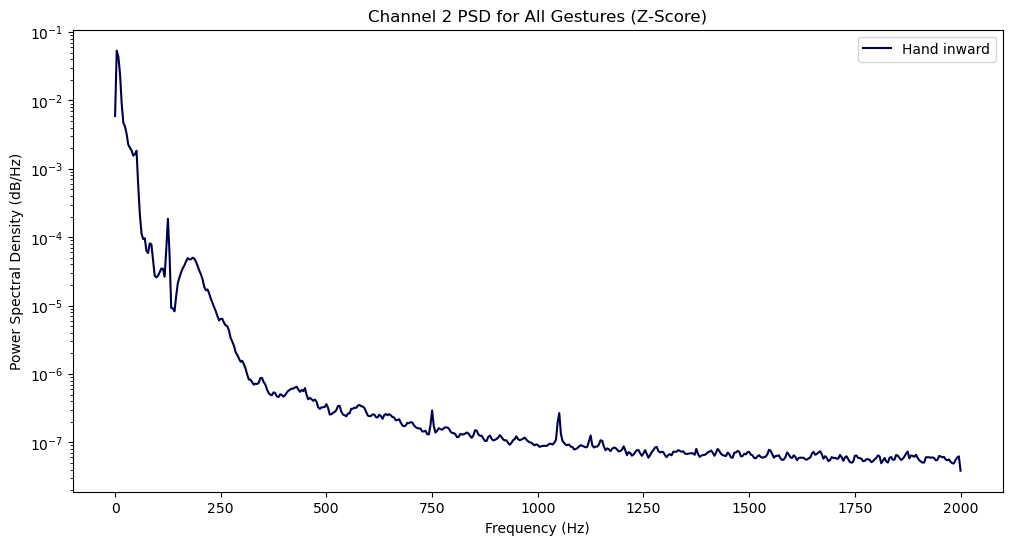

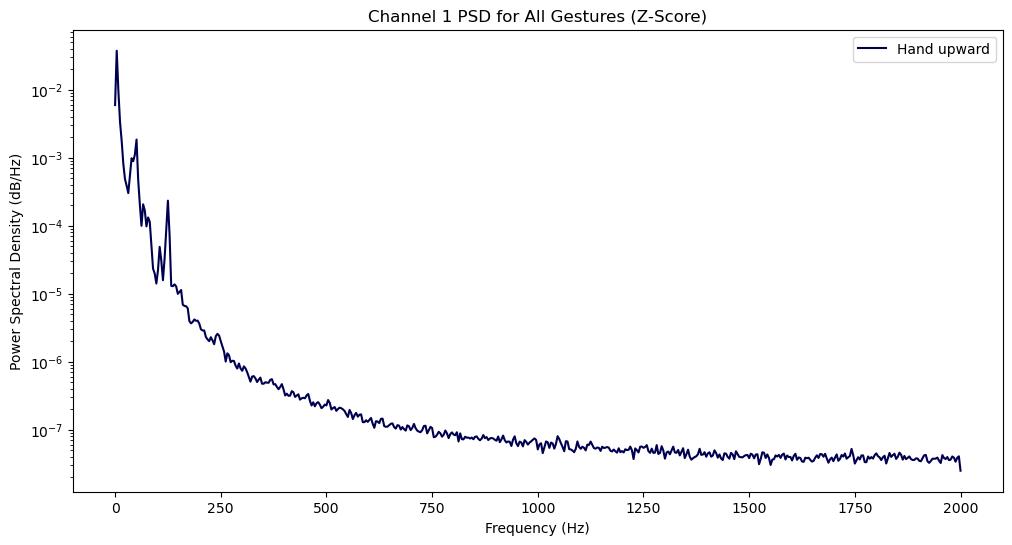

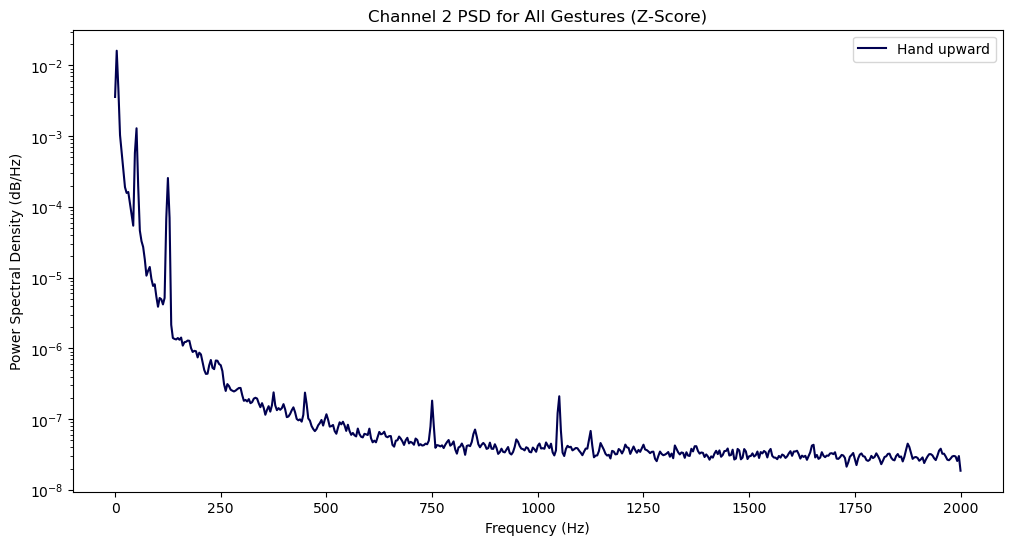

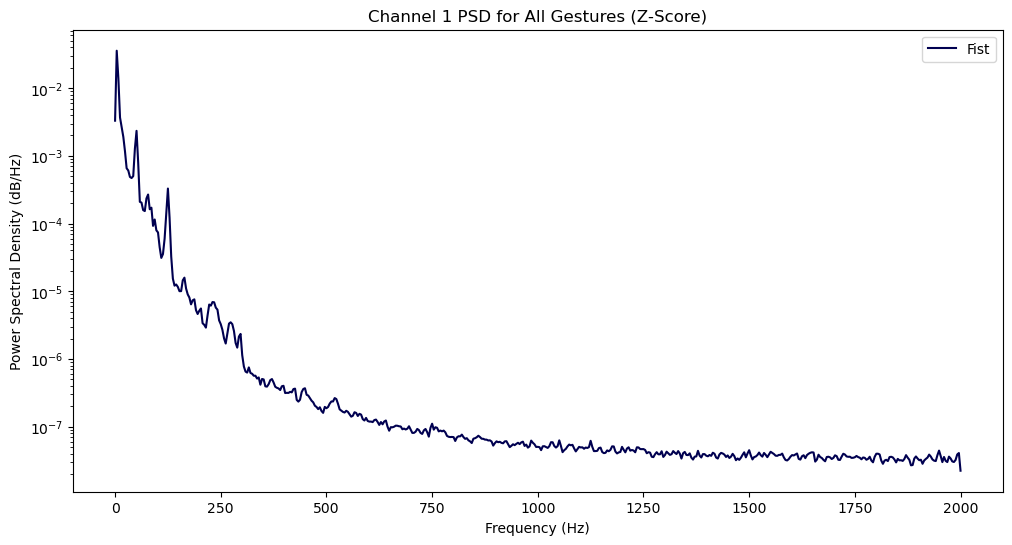

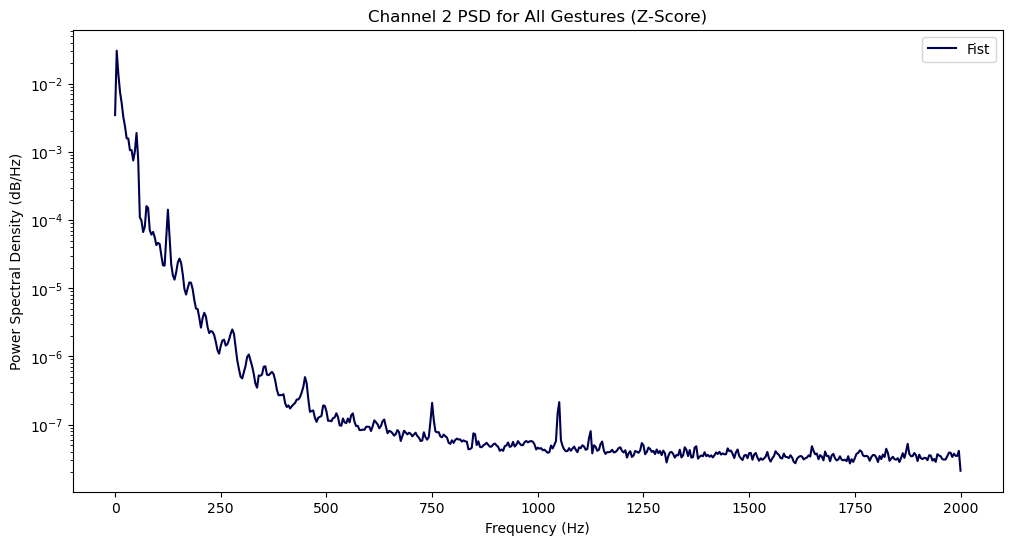

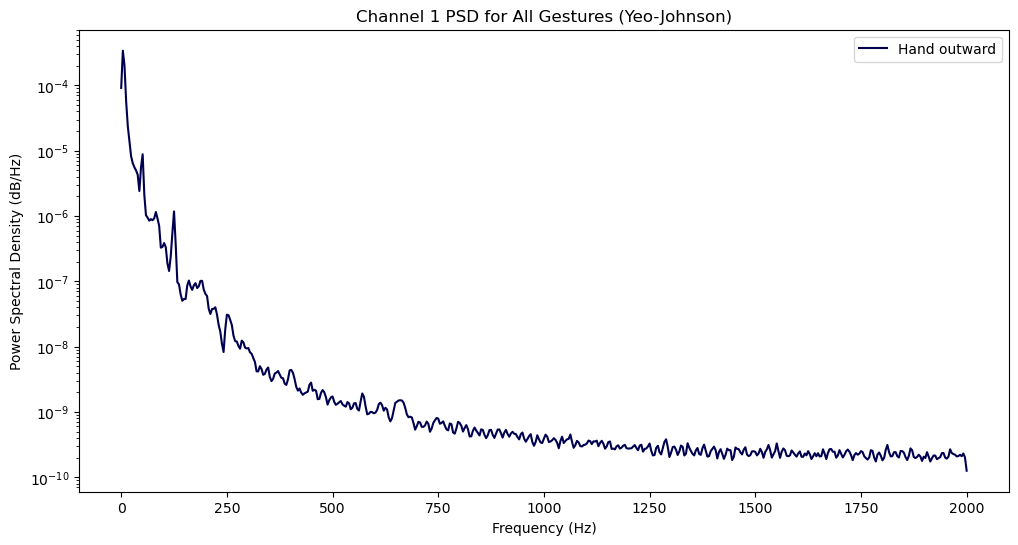

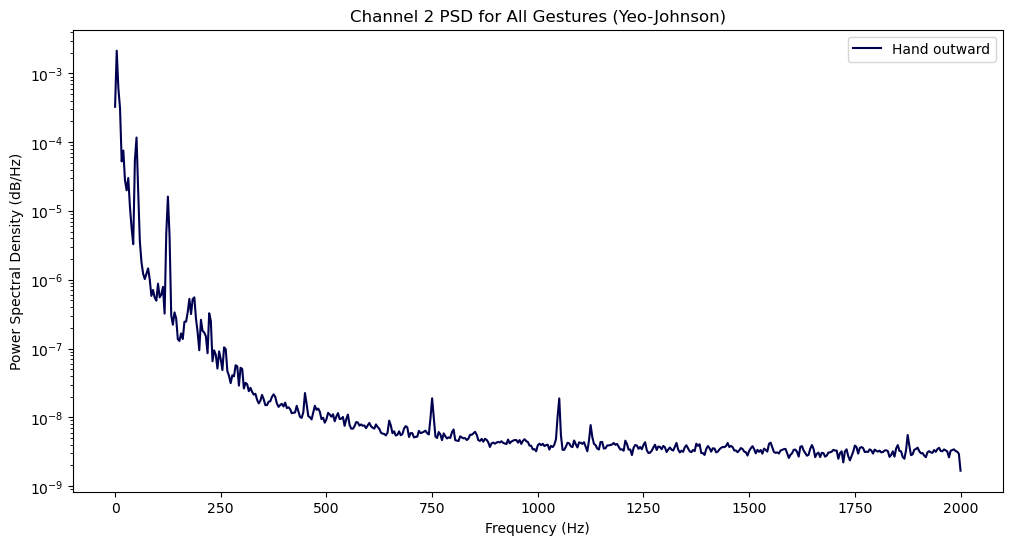

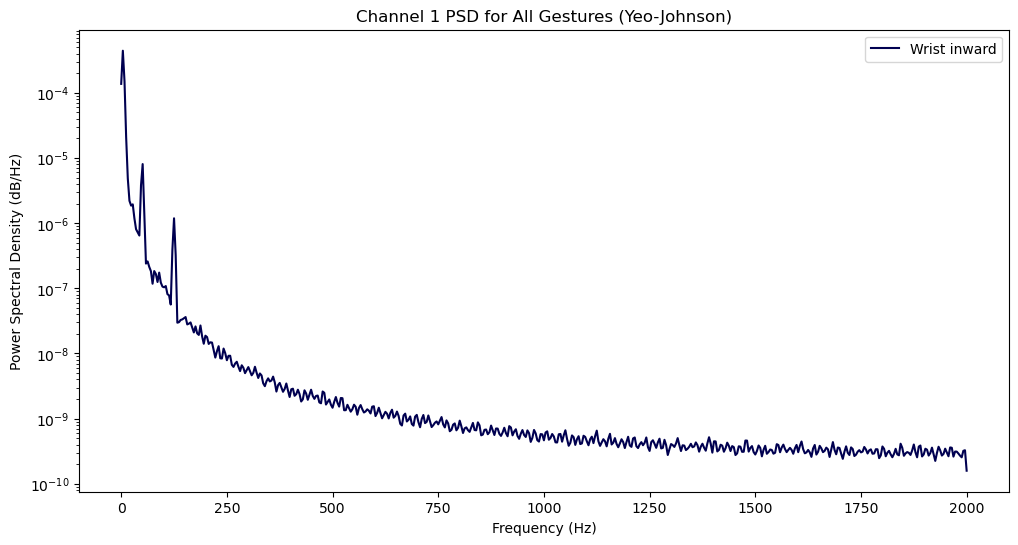

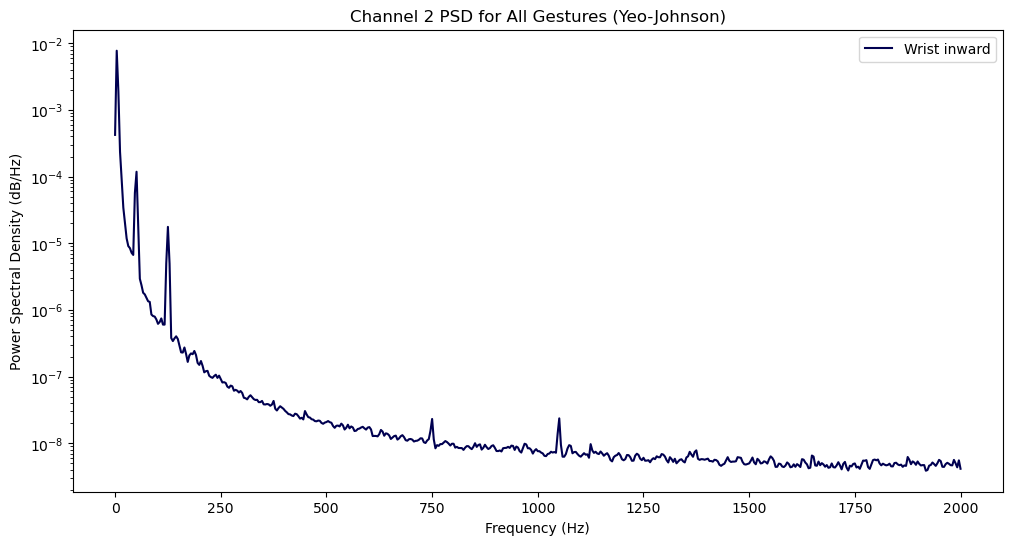

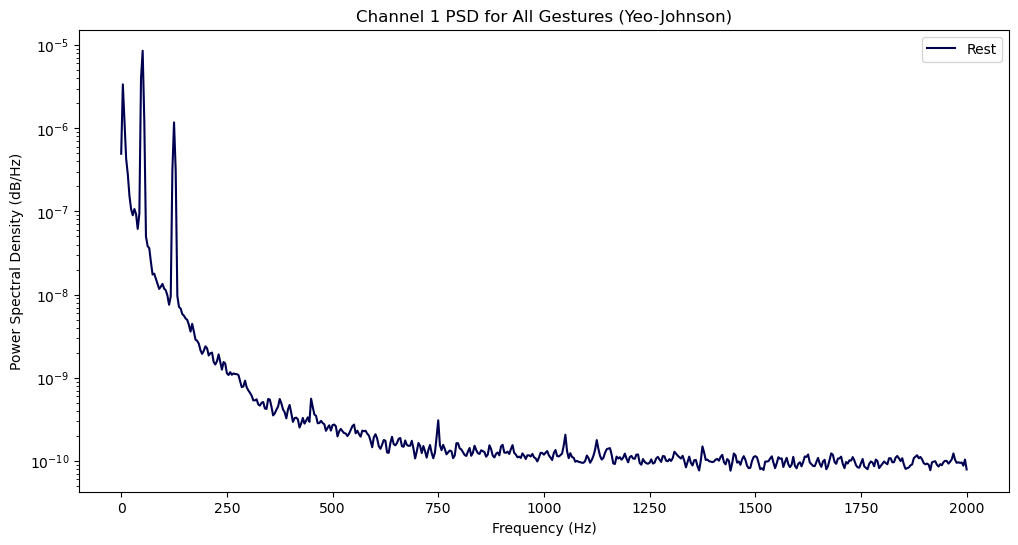

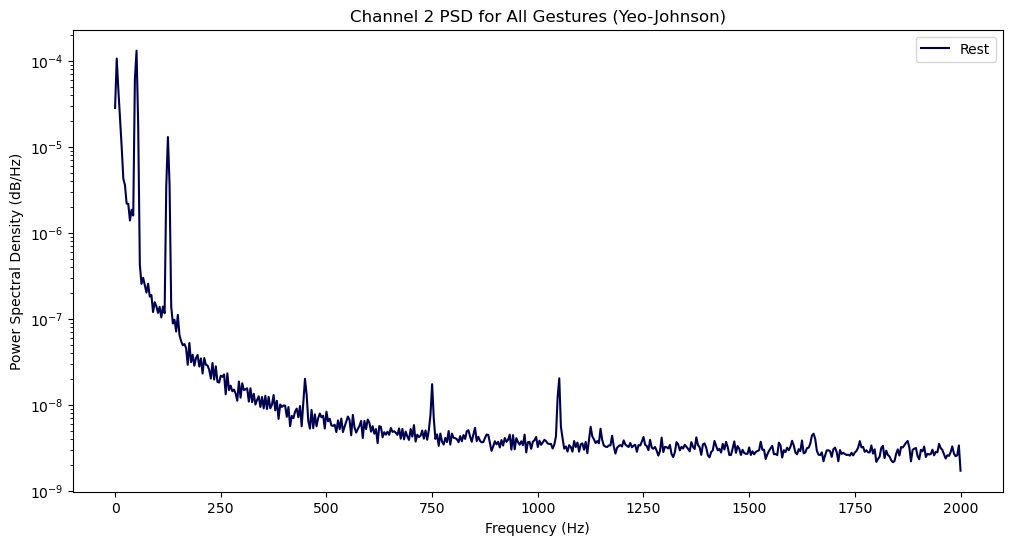

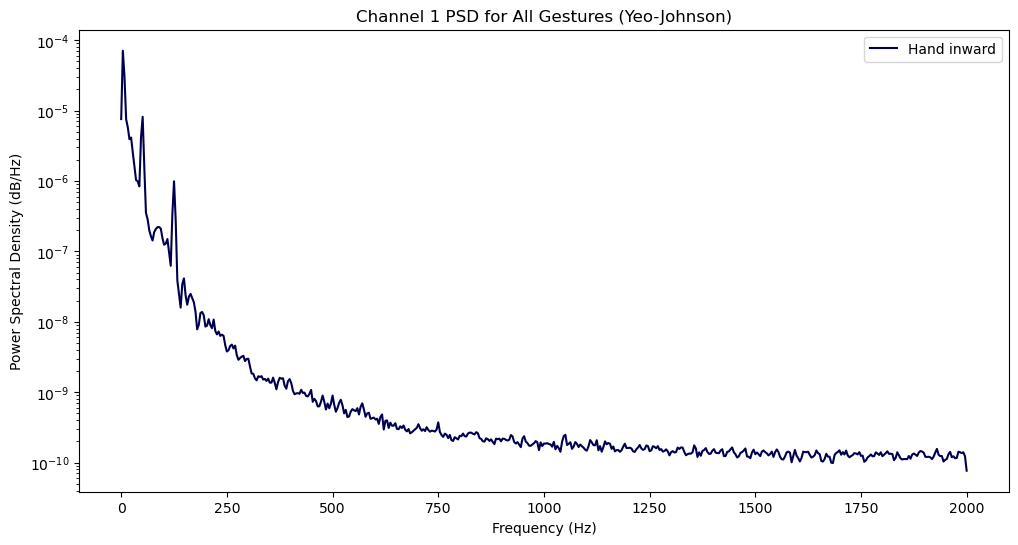

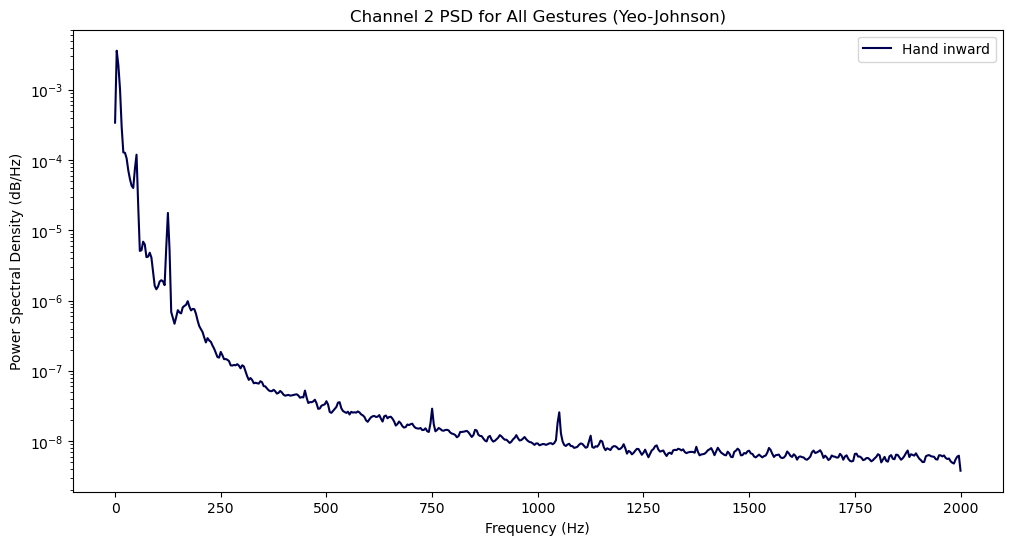

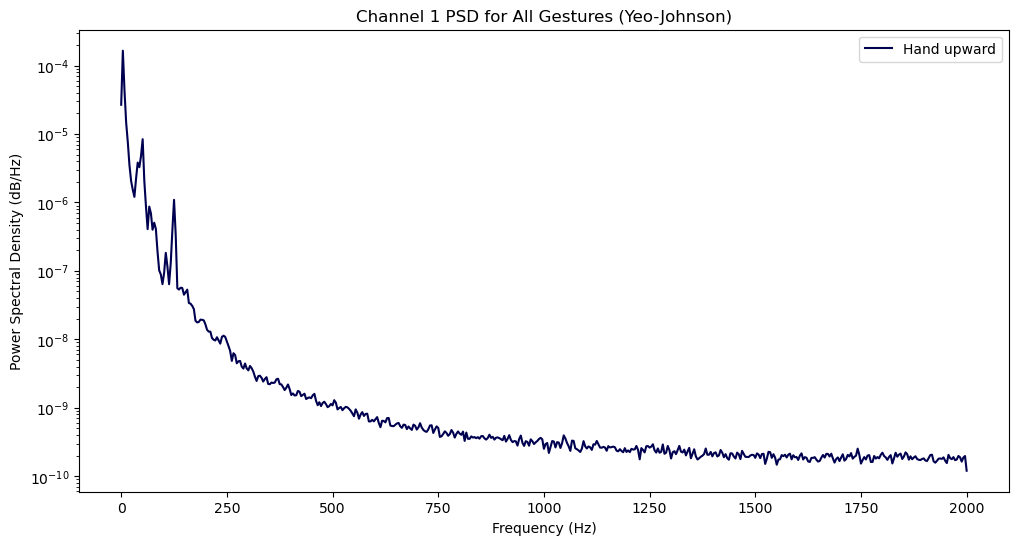

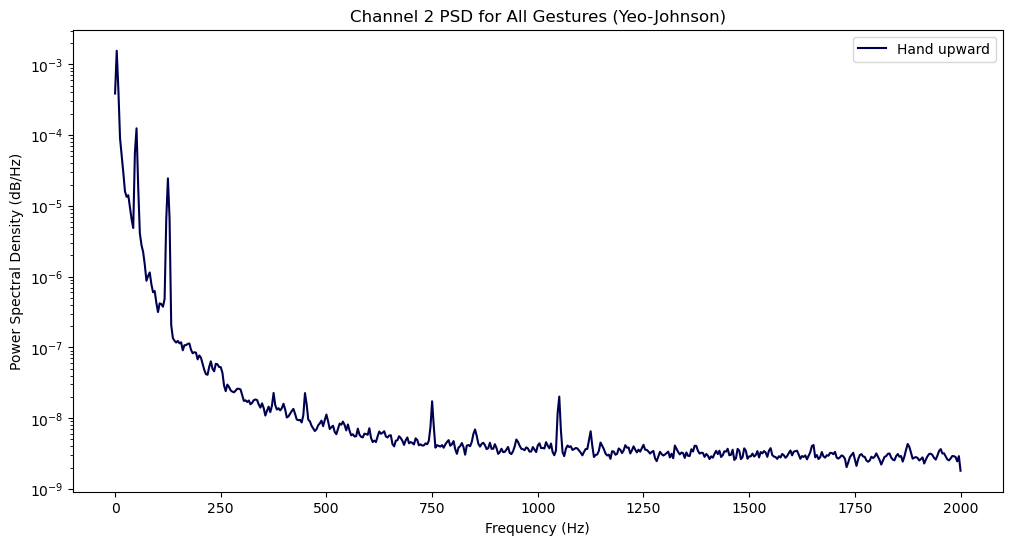

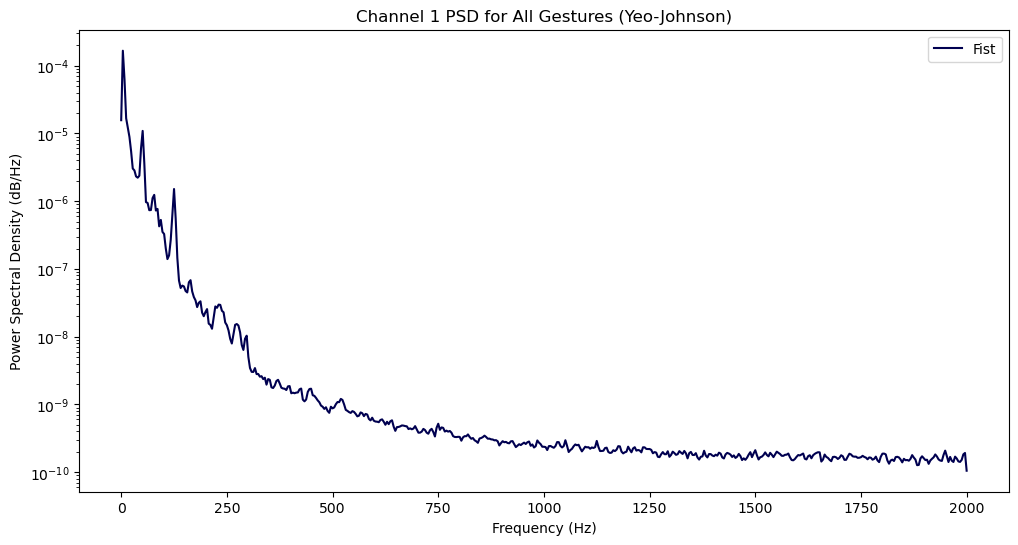

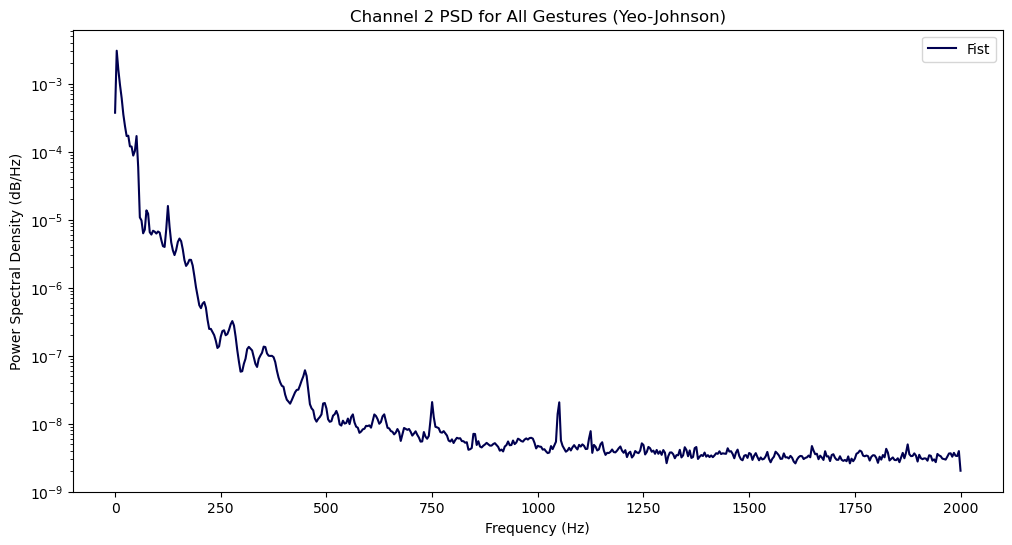

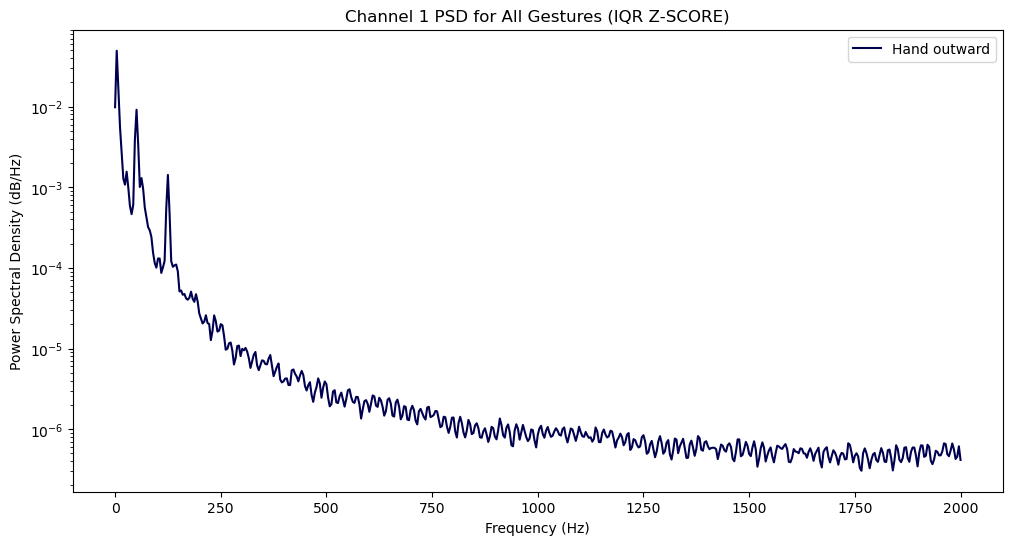

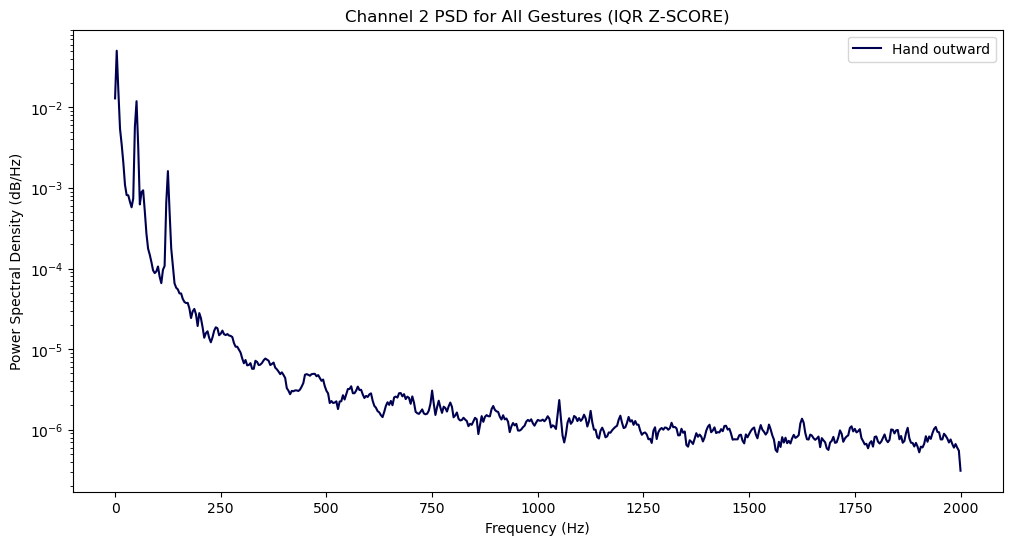

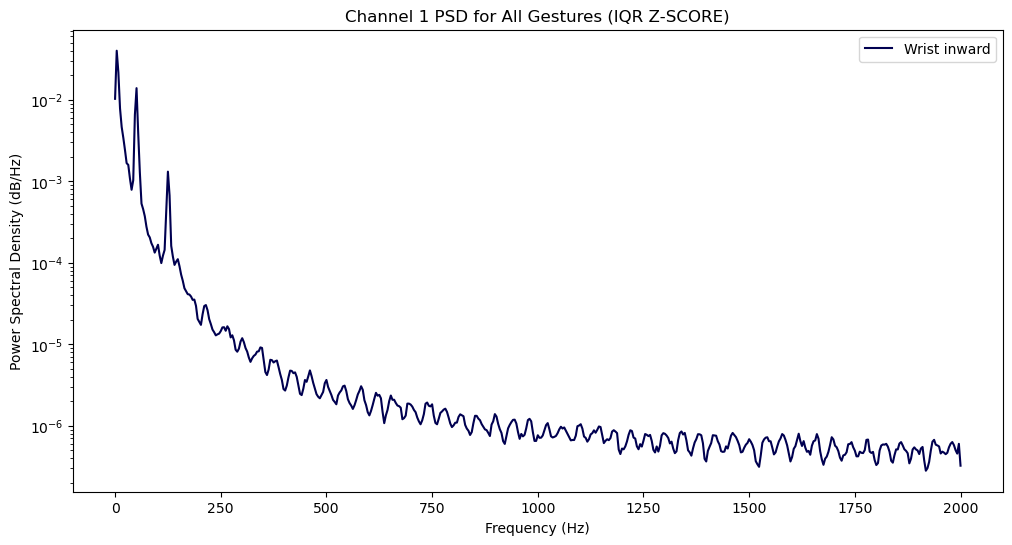

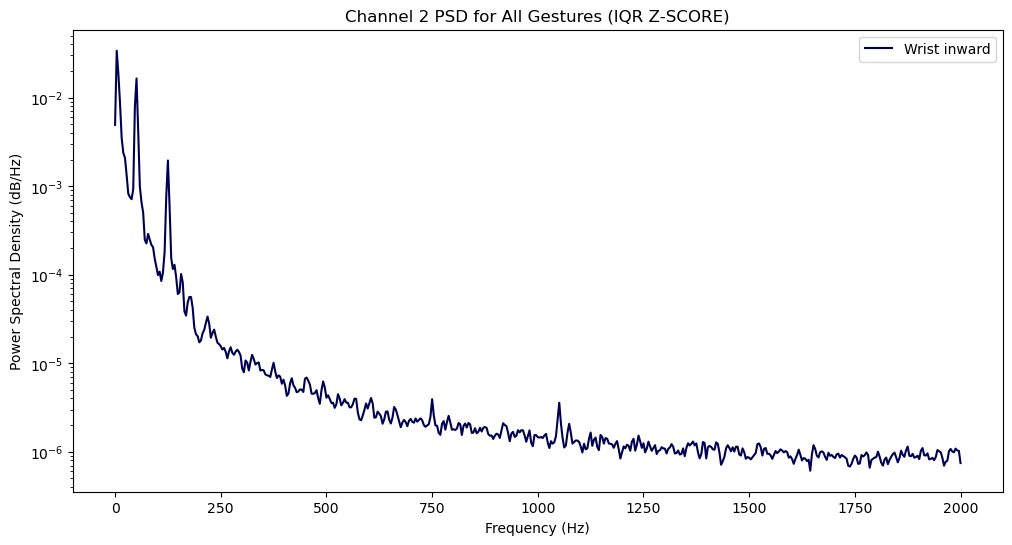

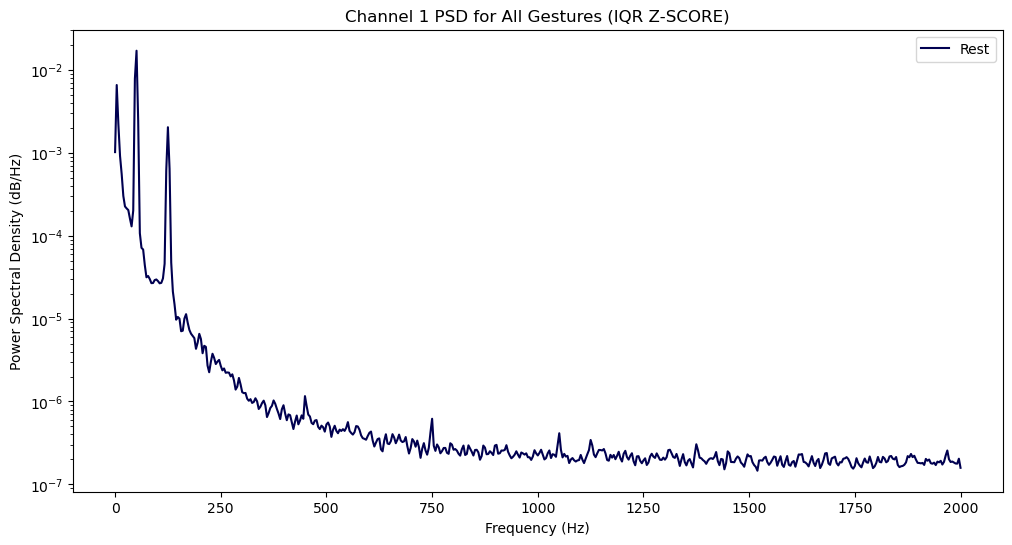

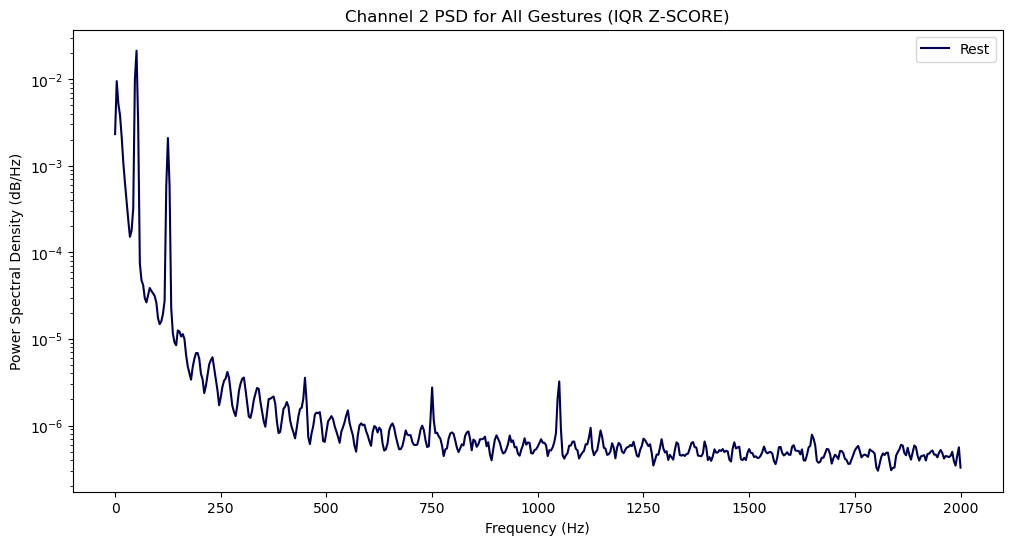

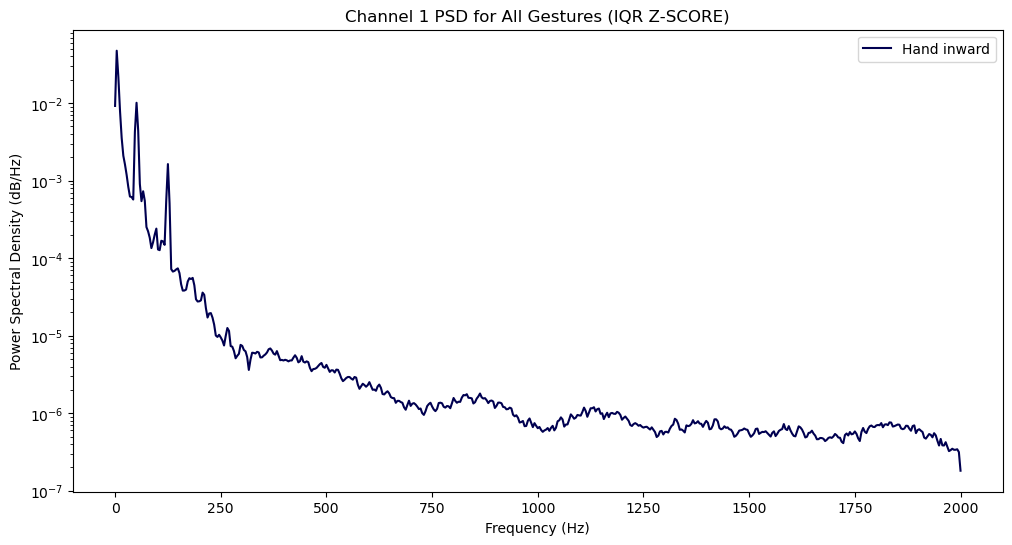

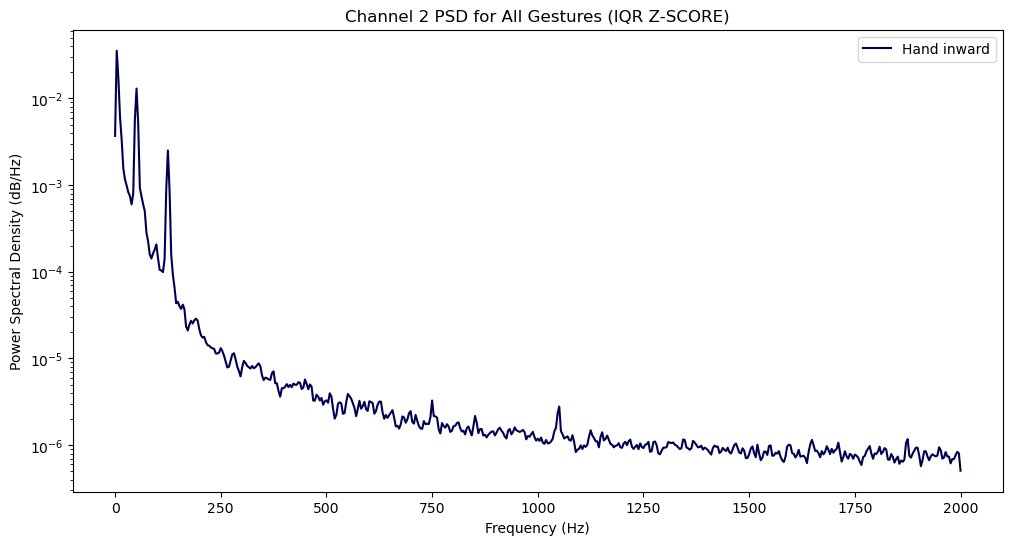

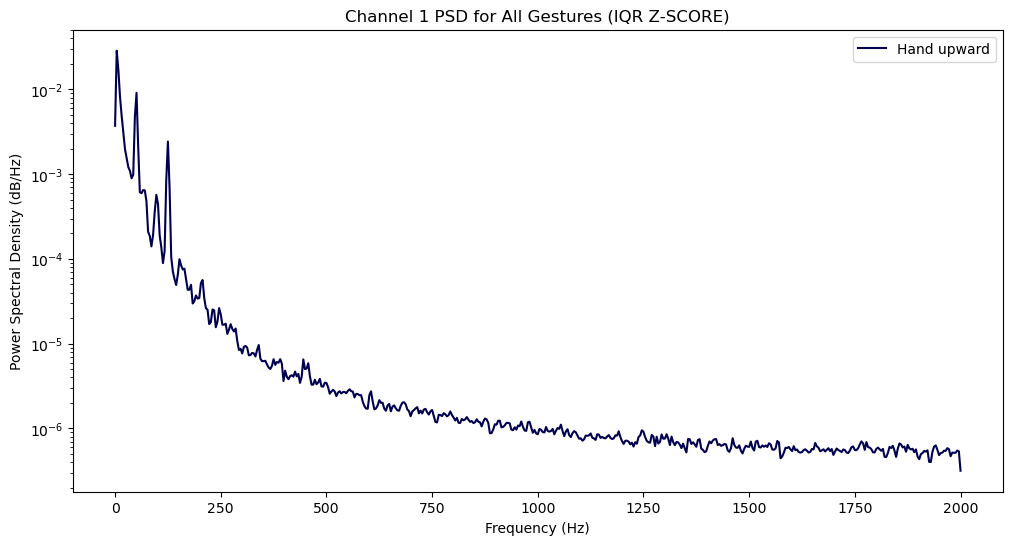

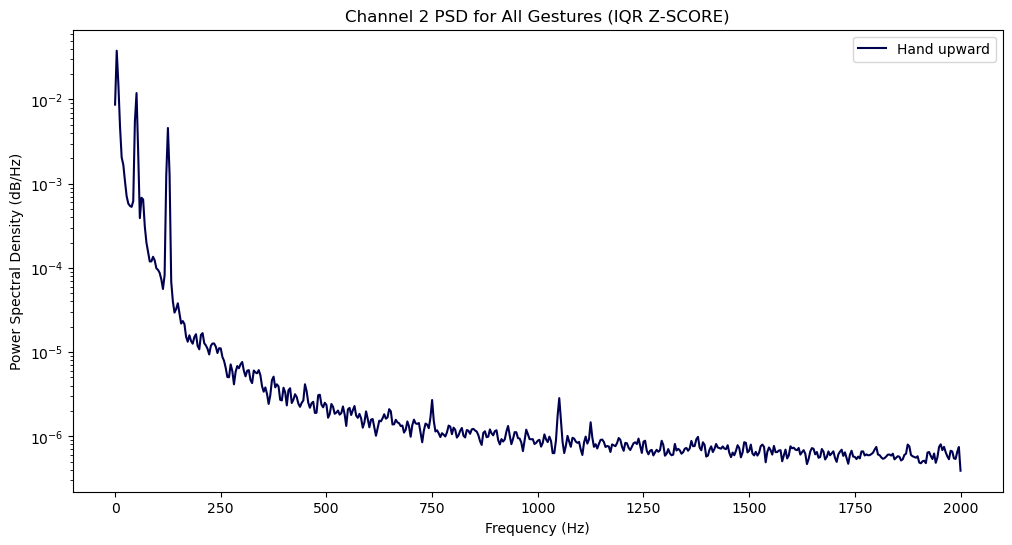

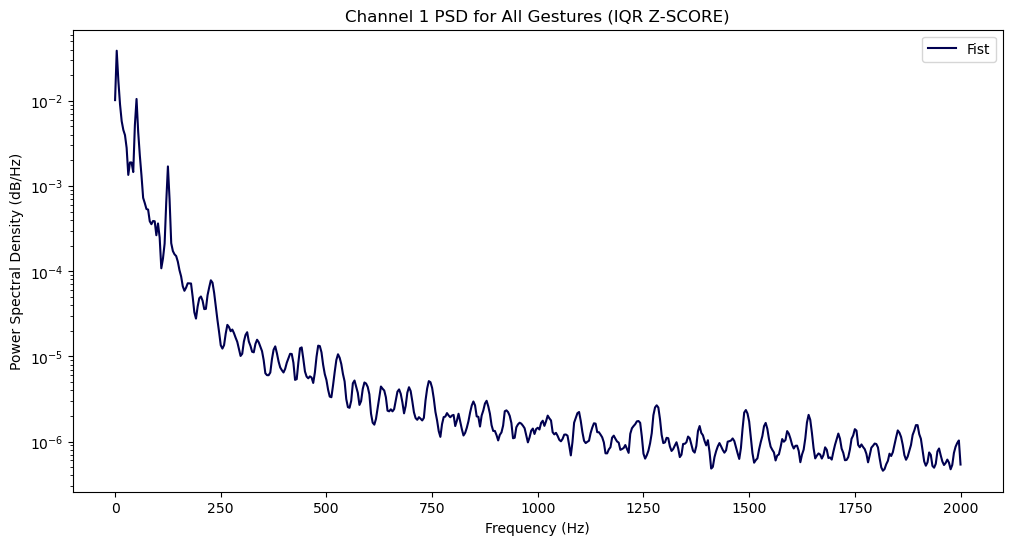

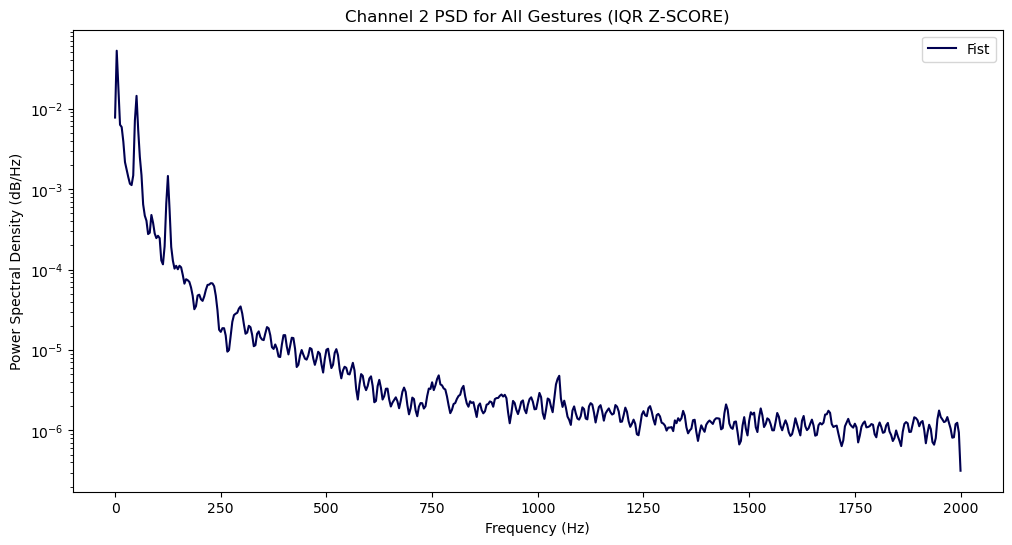

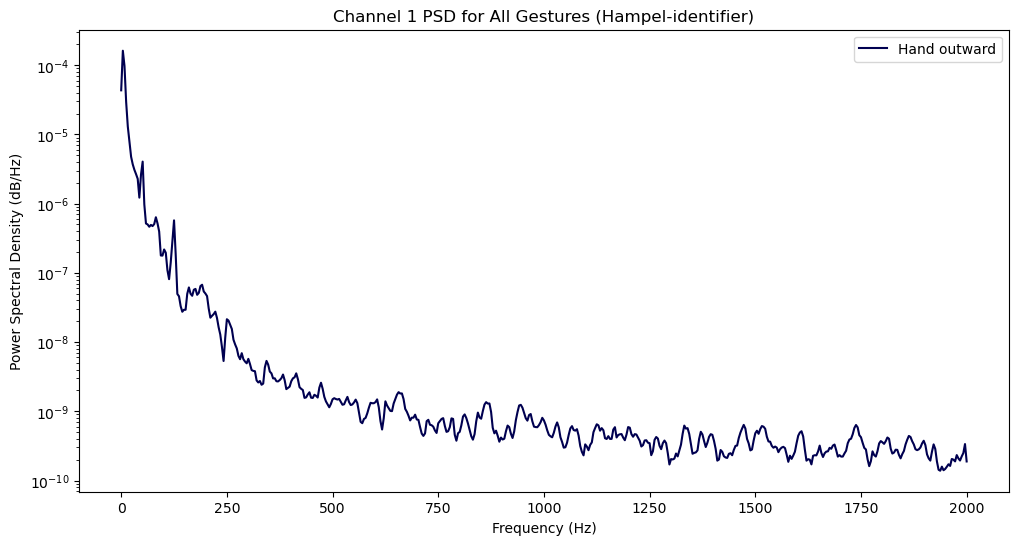

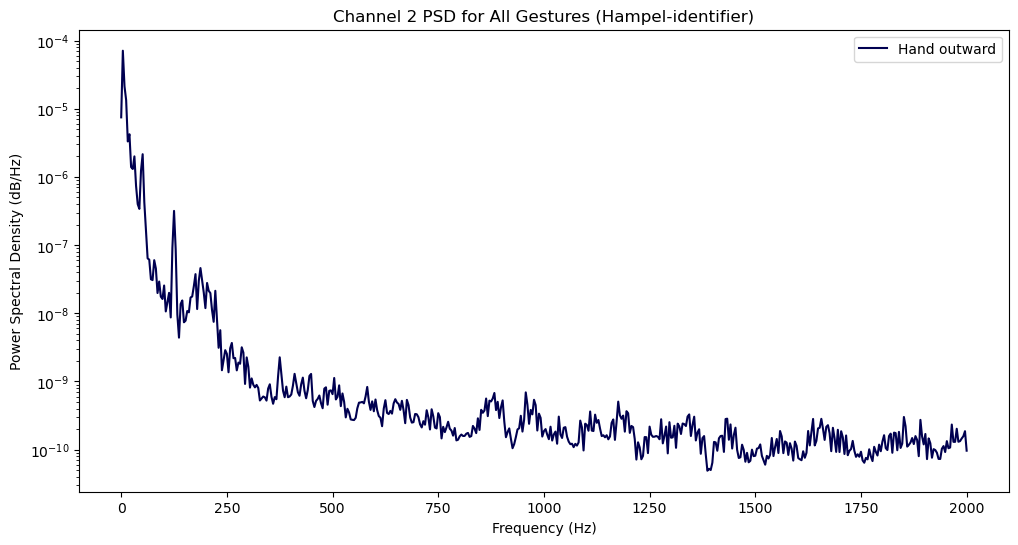

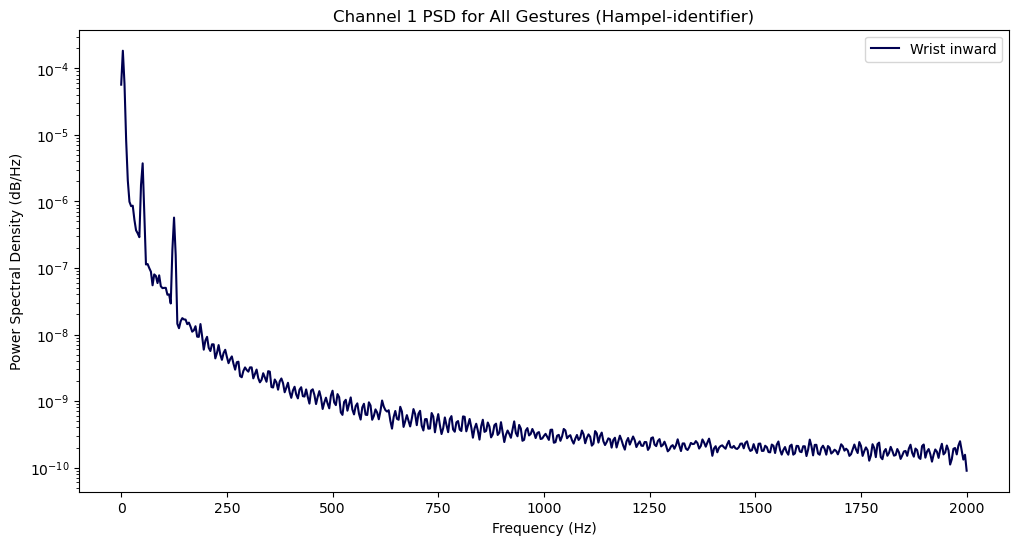

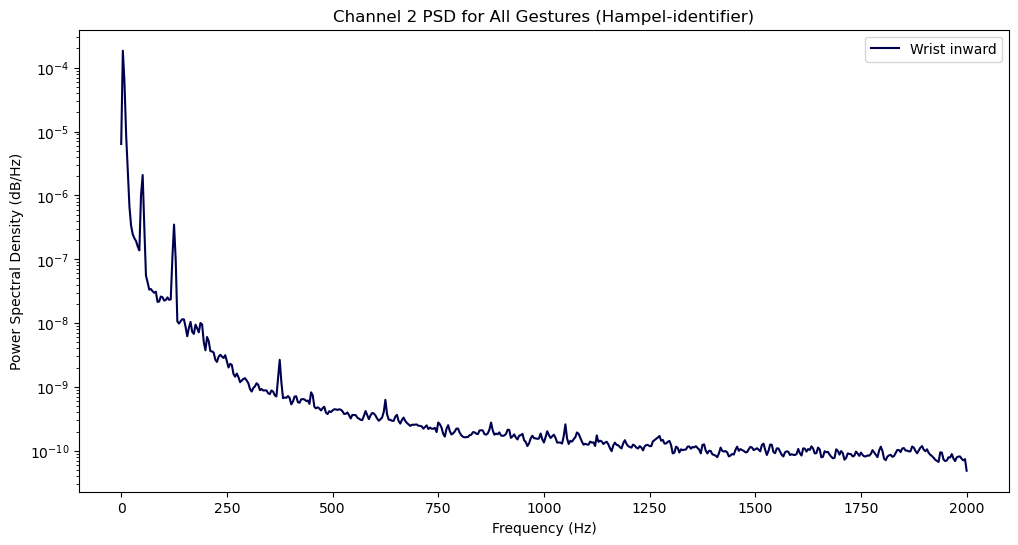

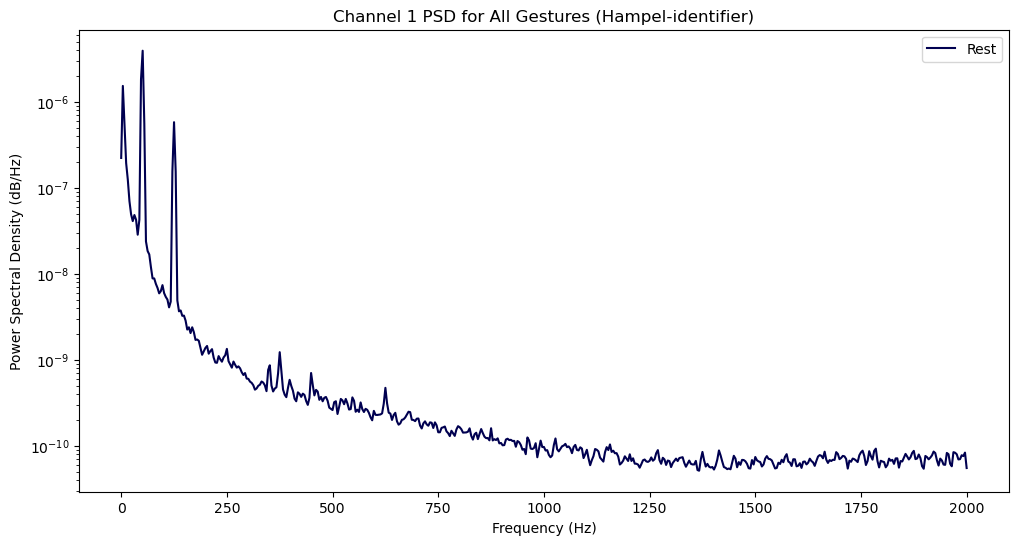

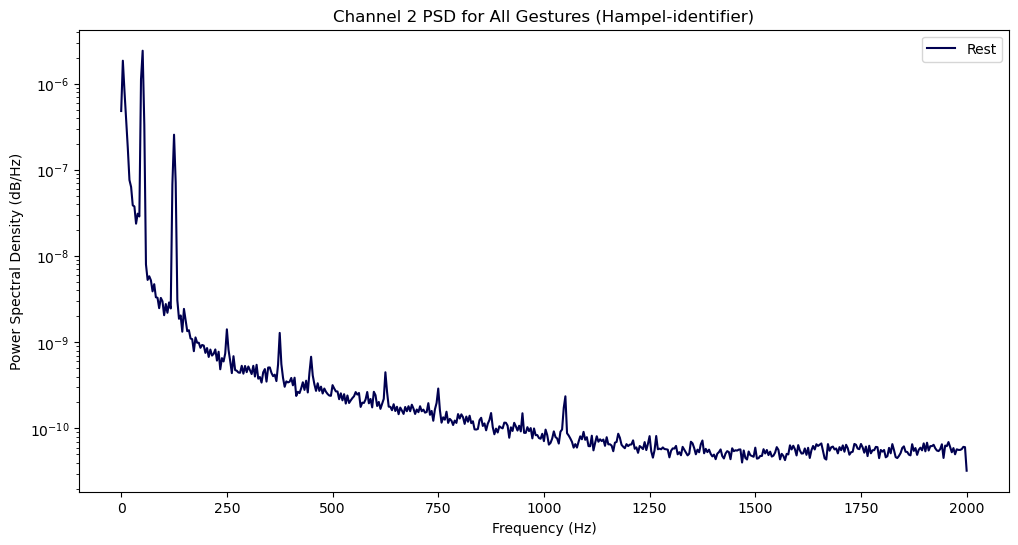

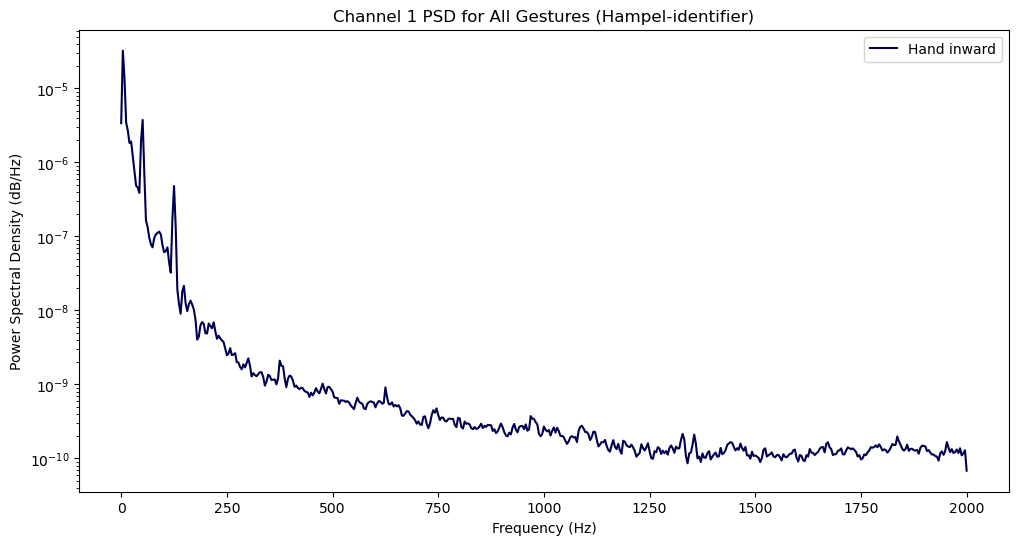

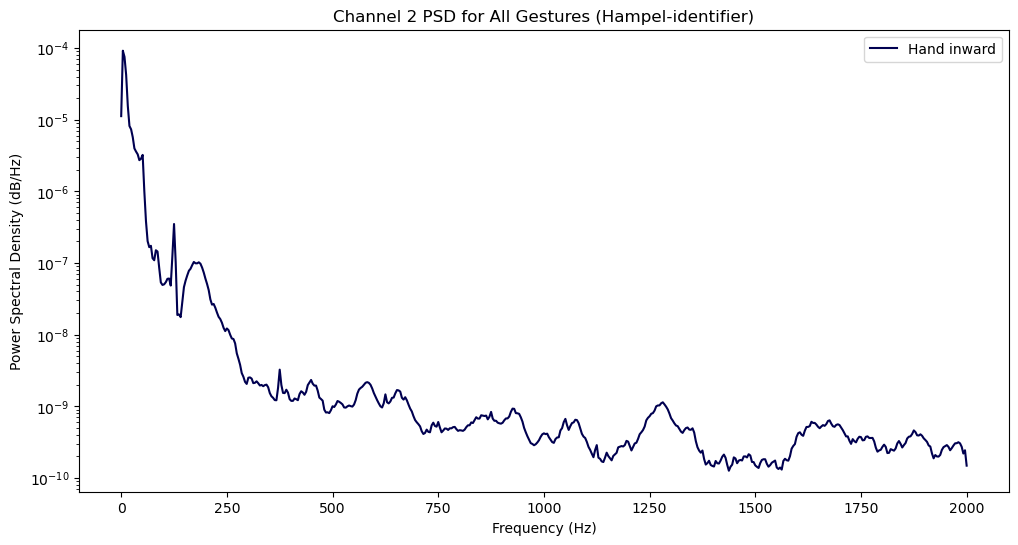

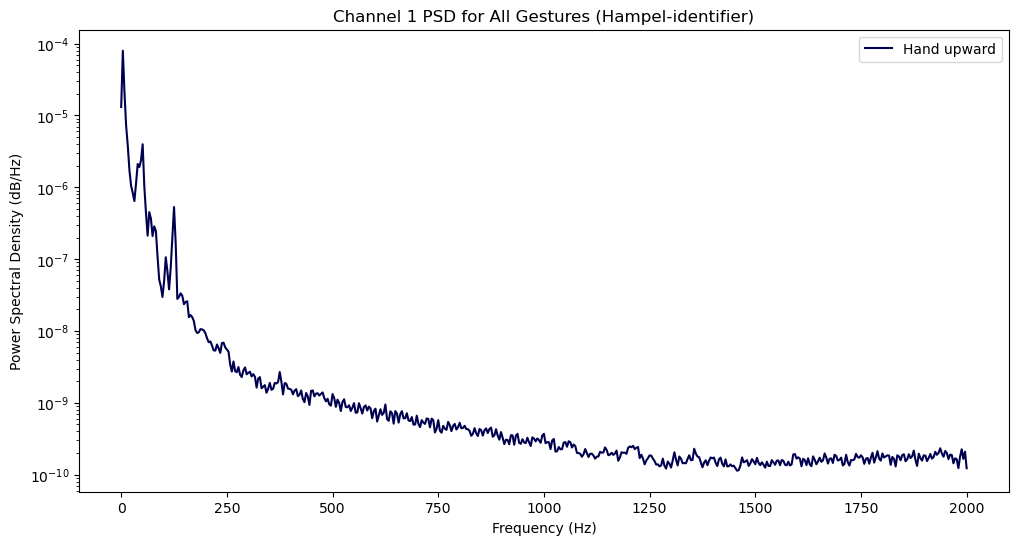

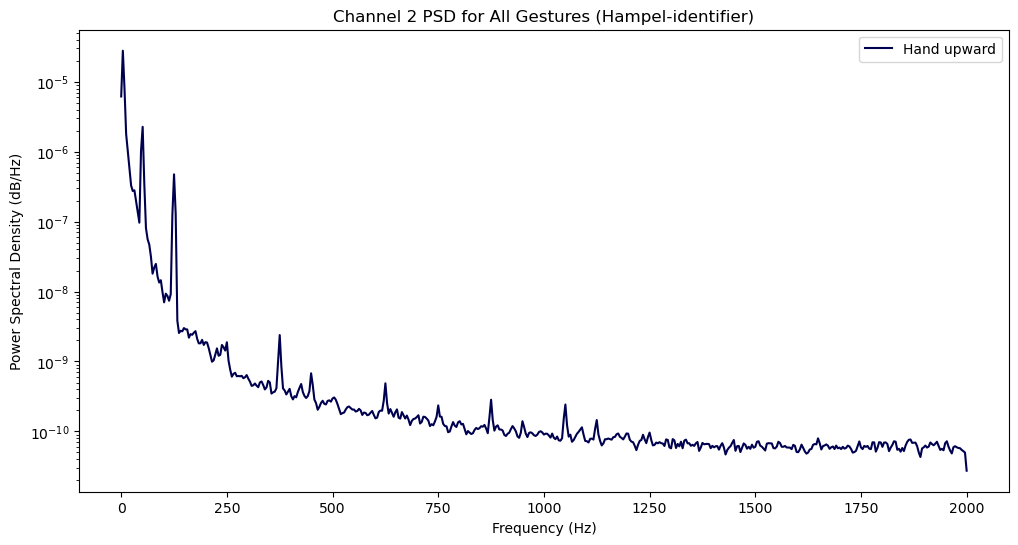

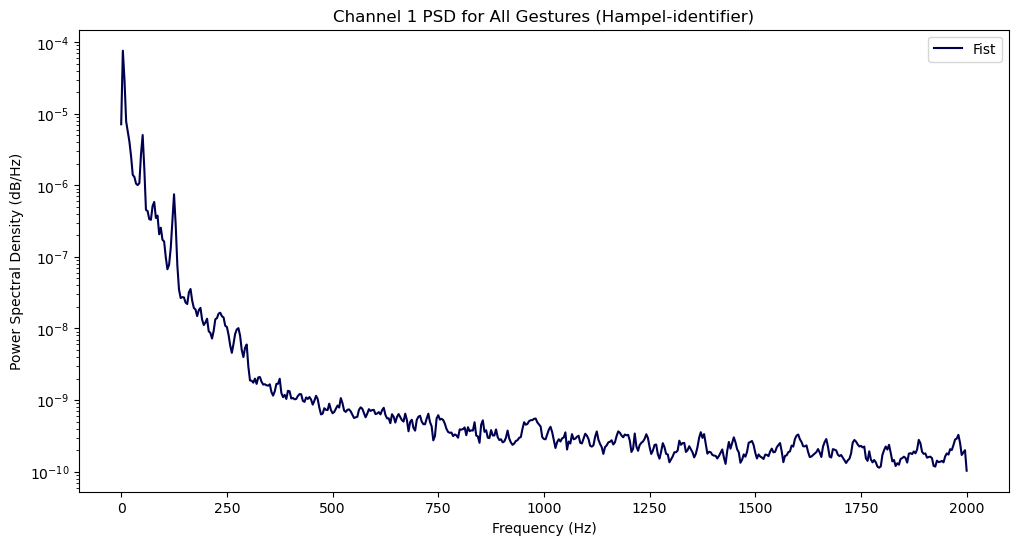

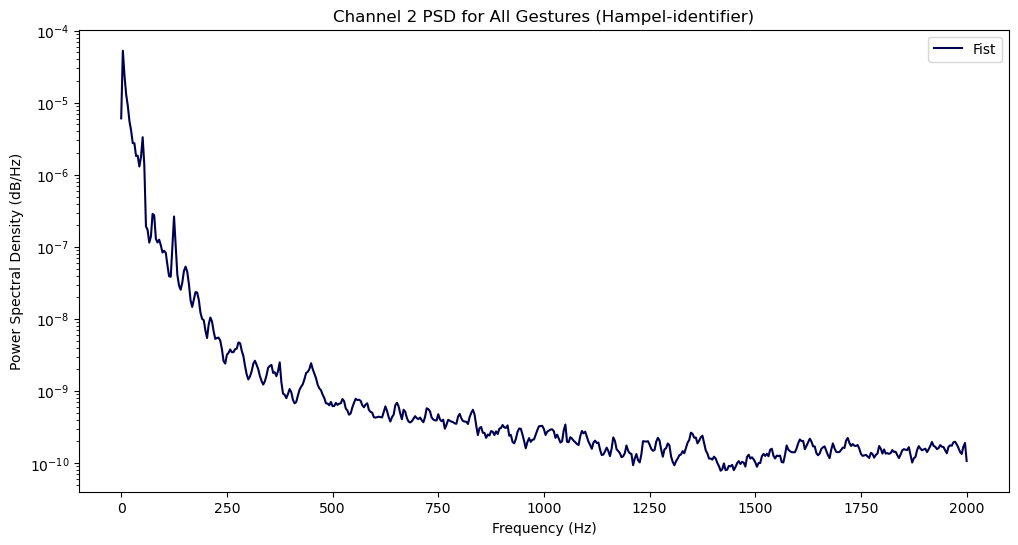

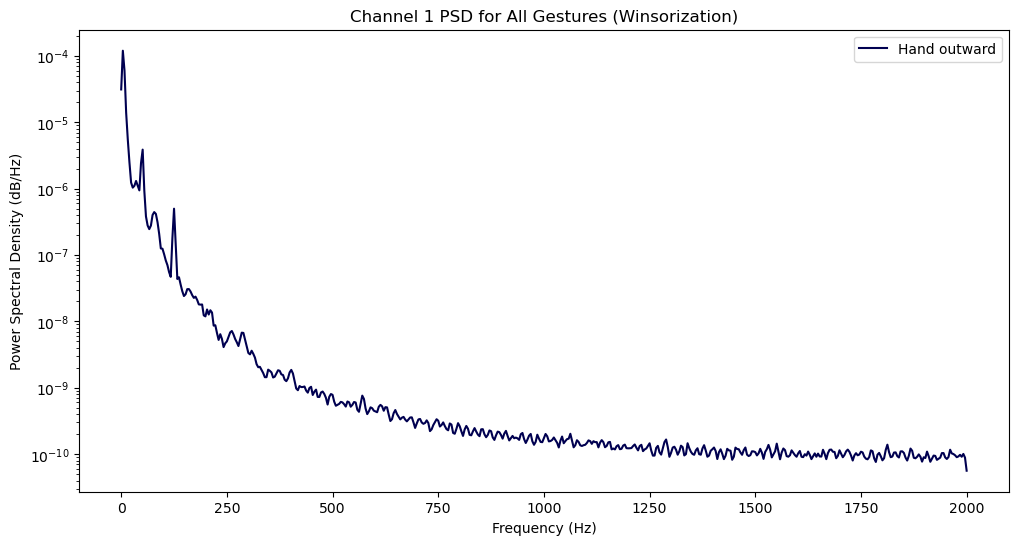

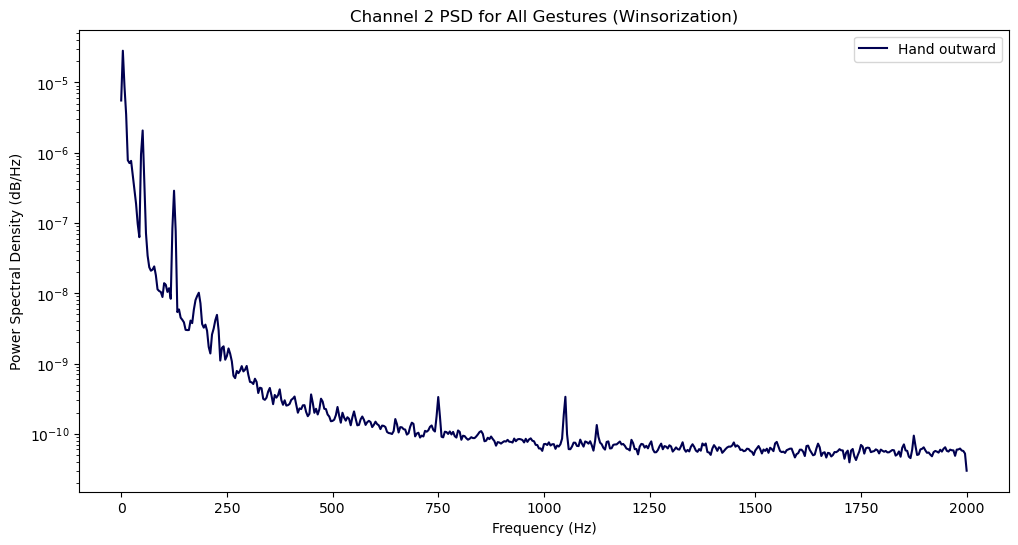

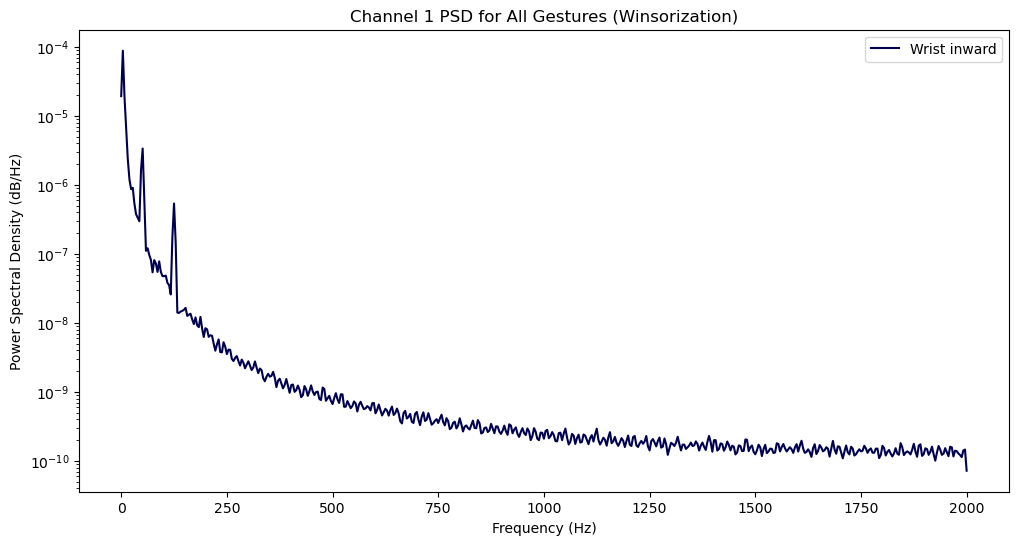

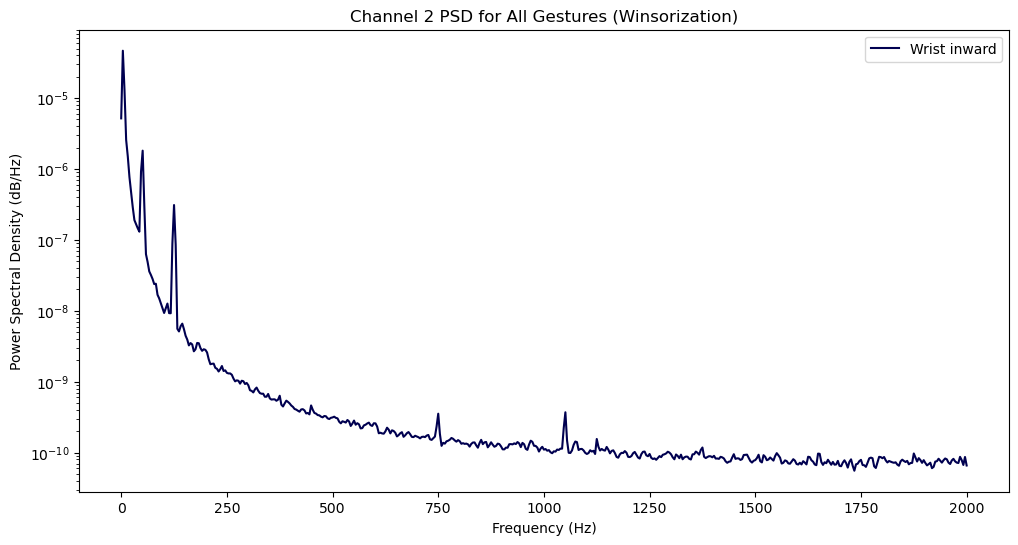

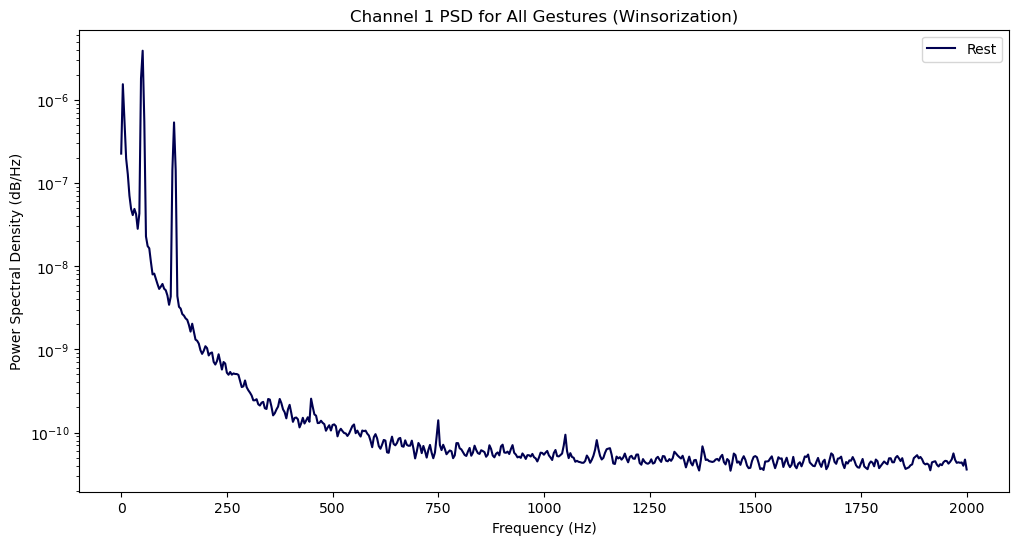

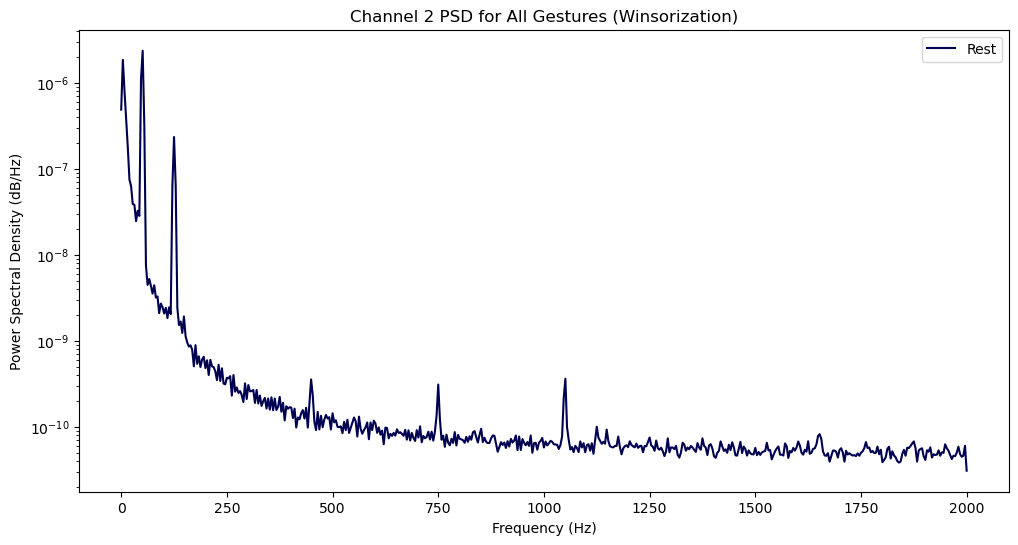

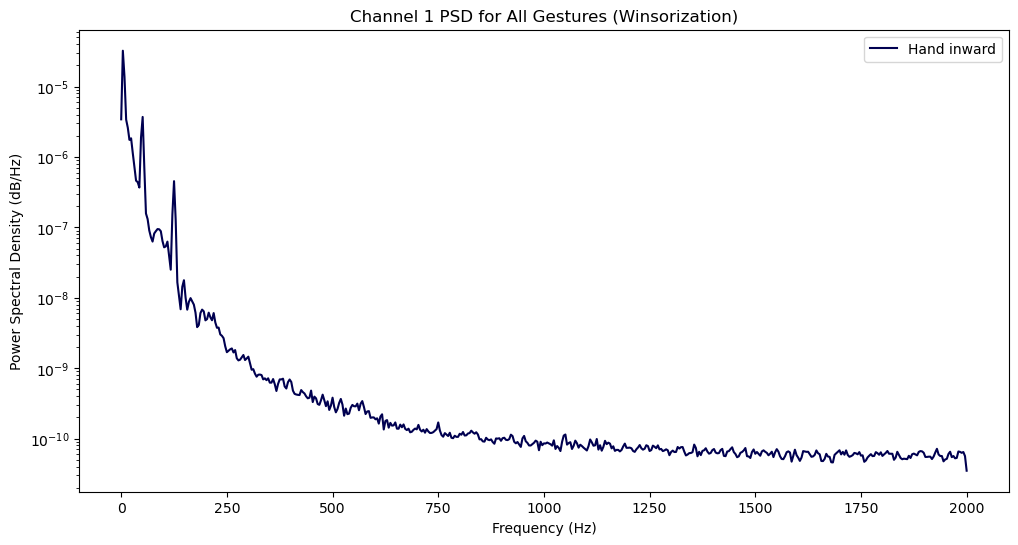

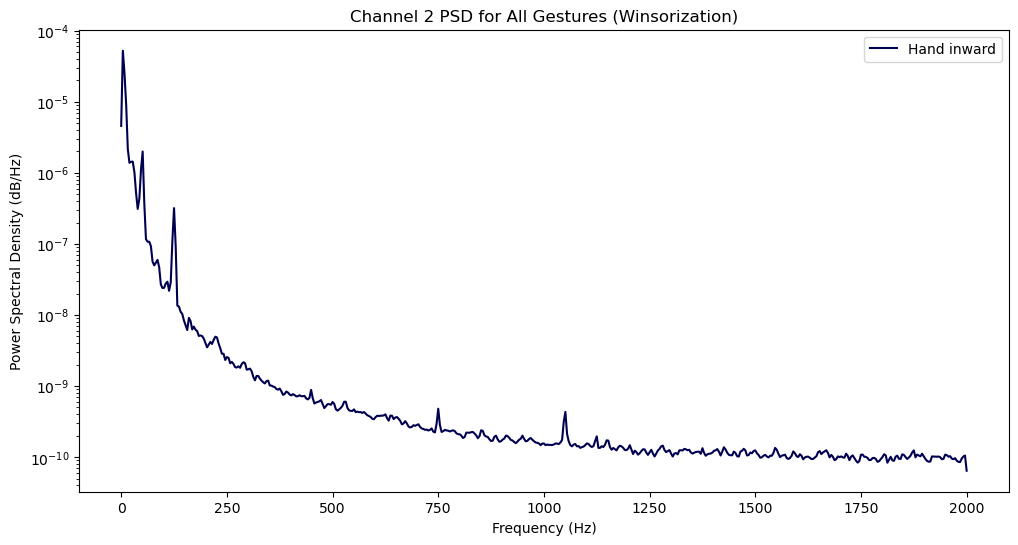

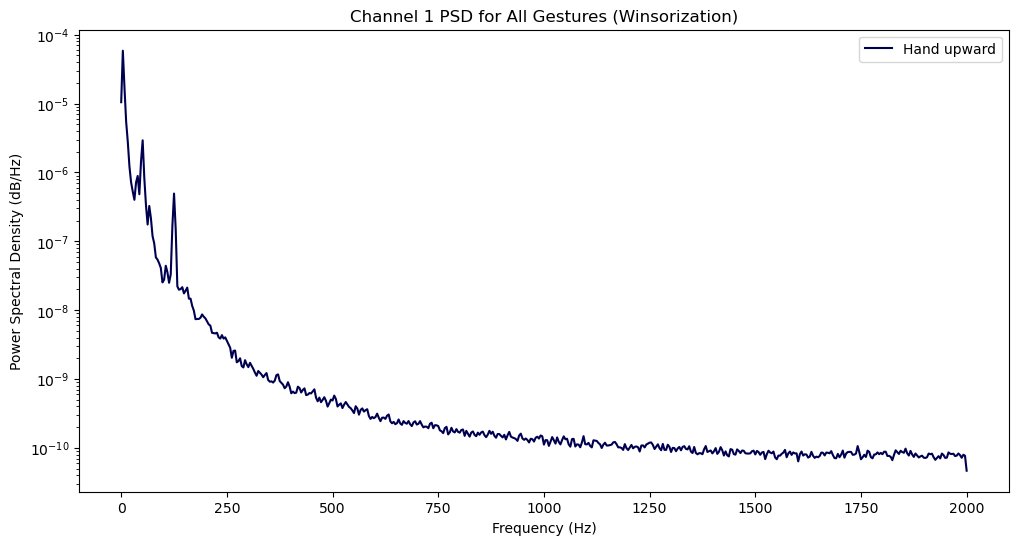

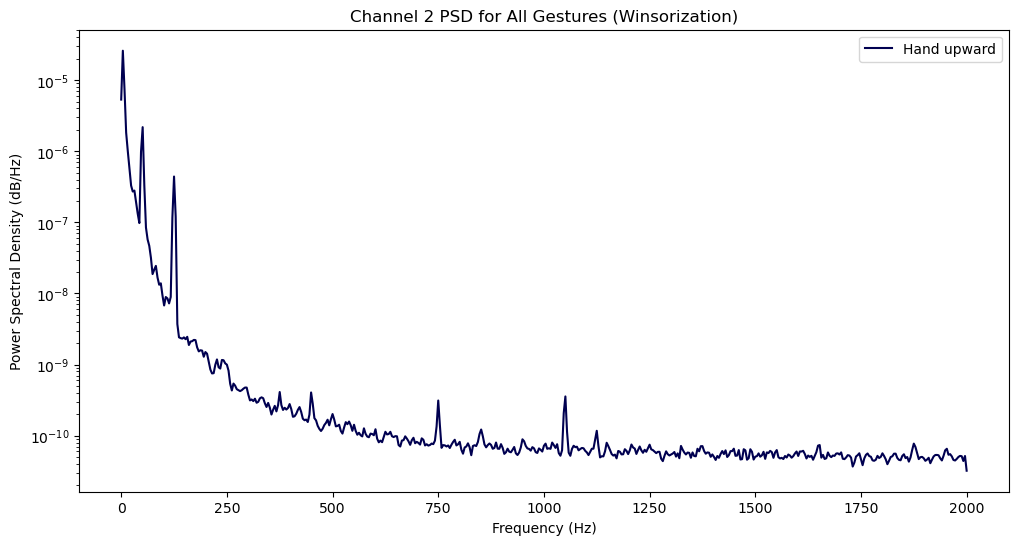

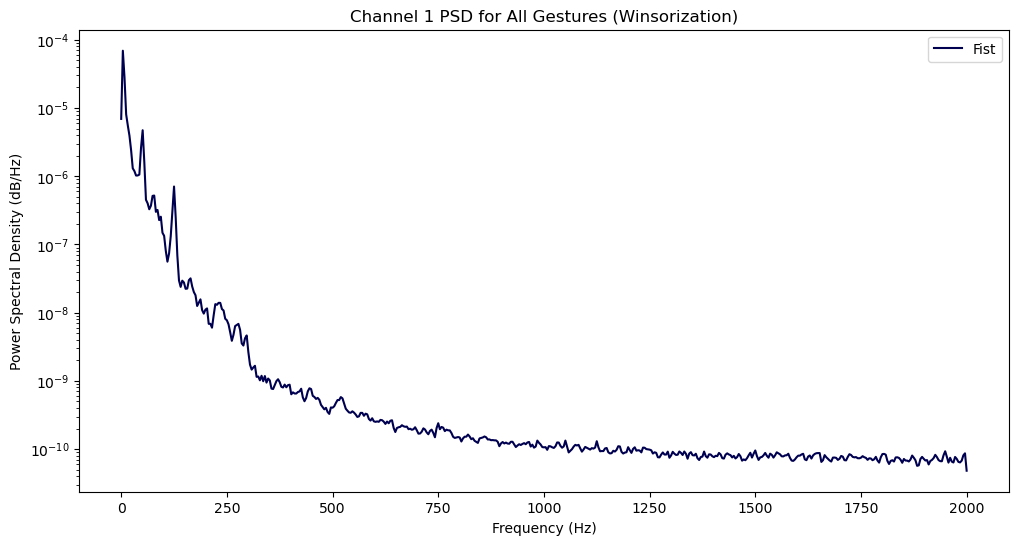

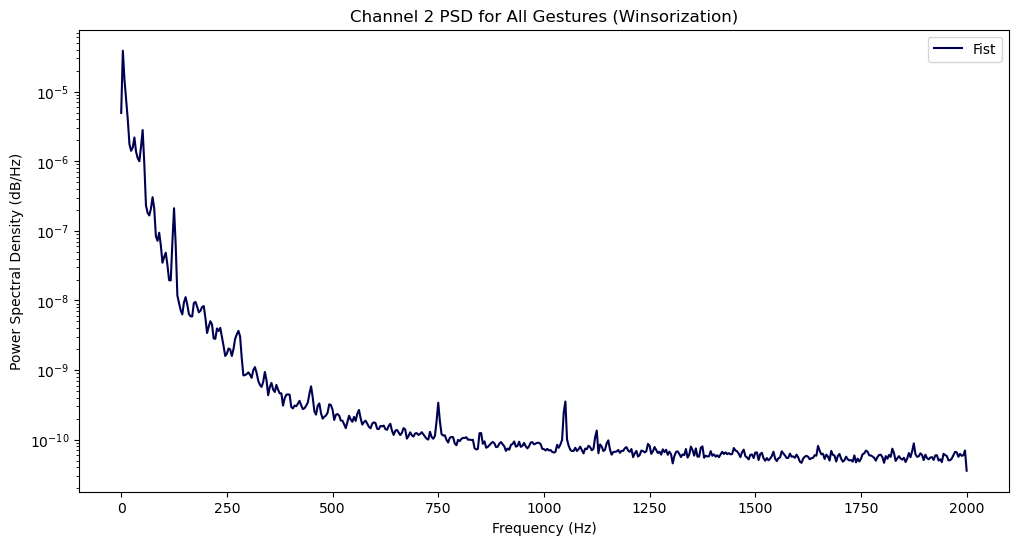

In [107]:
def plot_psd(df_filtered, channel, fs, preprocessing_method):
    plt.figure(figsize=(12, 6))
    
    for gesture in df_filtered['GestureName'].unique():
        gesture_df = df_filtered[df_filtered['GestureName'] == gesture]
        freqs, psd = welch(gesture_df[channel], fs, nperseg=1024)

        plt.semilogy(freqs, psd, label=gesture)
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.title(f'{channel} PSD for All Gestures ({preprocessing_method})')
    plt.legend()
    plt.show()


fs = 4000  # 
gesture_names = df['GestureName'].unique()

# Plot the PSD for the dropoutlier dataframe
for gesture_name in gesture_names:
    df_filtered = df_iqr[df_iqr['GestureName'] == gesture_name]
    plot_psd(df_filtered, 'Channel 1', fs, 'Drop Outlier')
    plot_psd(df_filtered, 'Channel 2', fs, 'Drop Outlier')

# Plot the PSD for the zscore dataframe
for gesture_name in gesture_names:
    df_filtered = df_zscore[df_zscore['GestureName'] == gesture_name]
    plot_psd(df_filtered, 'Channel 1', fs, 'Z-Score')
    plot_psd(df_filtered, 'Channel 2', fs, 'Z-Score')

#Plot the PSD for the robust z-score dataframe
for gesture_name in gesture_names:
    df_filtered = df_yeojohnson[df_yeojohnson['GestureName'] == gesture_name]
    plot_psd(df_filtered, 'Channel 1', fs, 'Yeo-Johnson')
    plot_psd(df_filtered, 'Channel 2', fs, 'Yeo-Johnson')

#Plot the PSD for the Yeo-Johnson dataframe
for gesture_name in gesture_names:
    df_filtered = df_iqr_zscore[df_iqr_zscore['GestureName'] == gesture_name]
    plot_psd(df_filtered, 'Channel 1', fs, 'IQR Z-SCORE')
    plot_psd(df_filtered, 'Channel 2', fs, 'IQR Z-SCORE')

#Plot the PSD for the Hampel-identifier dataframe
for gesture_name in gesture_names:
    df_filtered = df_hampel[df_hampel['GestureName'] == gesture_name]
    plot_psd(df_filtered, 'Channel 1', fs, 'Hampel-identifier')
    plot_psd(df_filtered, 'Channel 2', fs, 'Hampel-identifier')    

#Plot the PSD for the winsorized dataframe
for gesture_name in gesture_names:
    df_filtered = df_winsorized[df_winsorized['GestureName'] == gesture_name]
    plot_psd(df_filtered, 'Channel 1', fs, 'Winsorization')
    plot_psd(df_filtered, 'Channel 2', fs, 'Winsorization')


## Bandpass Filter

This section of the code defines the bandpass filter function and applies it to the sEMG data for each of the six preprocessed dataframes.

In [91]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

fs = 6000  # Set the sampling frequency
lowcut = 1  # Set the lower cutoff frequency
highcut = 200  # Set the upper cutoff frequency

for participant in df['ParticipantName'].unique():
    participant_df = df[df['ParticipantName'] == participant].copy()
    
    # Apply the filter to both channels
    participant_df['Filtered Channel 1'] = butter_bandpass_filter(participant_df['Channel 1'], lowcut, highcut, fs)
    participant_df['Filtered Channel 2'] = butter_bandpass_filter(participant_df['Channel 2'], lowcut, highcut, fs)

    df_temp = df.loc[participant_df.index].copy()
    df_temp['Filtered Channel 1'] = participant_df['Filtered Channel 1']
    df_temp['Filtered Channel 2'] = participant_df['Filtered Channel 2']
    
    df.loc[participant_df.index, 'Filtered Channel 1'] = df_temp['Filtered Channel 1']
    df.loc[participant_df.index, 'Filtered Channel 2'] = df_temp['Filtered Channel 2']

In [150]:
df_zscore_filtered = df_zscore.copy()
df_zscore_filtered['Filtered Channel 1'] = butter_bandpass_filter(df_zscore_filtered['Channel 1'], 1, 200, 5000)
df_zscore_filtered['Filtered Channel 2'] = butter_bandpass_filter(df_zscore_filtered['Channel 2'], 1, 200, 5000)


df_iqr_filtered = df_iqr.copy()
df_iqr_filtered['Filtered Channel 1'] = butter_bandpass_filter(df_iqr_filtered['Channel 1'], 1, 200, 5000)
df_iqr_filtered['Filtered Channel 2'] = butter_bandpass_filter(df_iqr_filtered['Channel 2'], 1, 200, 5000)

df_hampel_filtered = df_hampel.copy()
df_hampel_filtered['Filtered Channel 1'] = butter_bandpass_filter(df_hampel_filtered['Channel 1'], 1, 200, 5000)
df_hampel_filtered['Filtered Channel 2'] = butter_bandpass_filter(df_hampel_filtered['Channel 2'], 1, 200, 5000)

df_yeojohnson_filtered = df_yeojohnson.copy()
df_yeojohnson_filtered['Filtered Channel 1'] = butter_bandpass_filter(df_yeojohnson_filtered['Channel 1'], 1, 300, 4000)
df_yeojohnson_filtered['Filtered Channel 2'] = butter_bandpass_filter(df_yeojohnson_filtered['Channel 2'], 1, 300, 4000)

df_iqr_zscore_filtered = df_iqr_zscore.copy()
df_iqr_zscore_filtered['Filtered Channel 1'] = butter_bandpass_filter(df_iqr_zscore_filtered['Channel 1'], 1, 250, 4000)
df_iqr_zscore_filtered['Filtered Channel 2'] = butter_bandpass_filter(df_iqr_zscore_filtered['Channel 2'], 1, 250, 4000)

df_winsorized_filtered = df_winsorized.copy()
df_winsorized_filtered['Filtered Channel 1'] = butter_bandpass_filter(df_winsorized_filtered['Channel 1'], 1, 250, 4000)
df_winsorized_filtered['Filtered Channel 2'] = butter_bandpass_filter(df_winsorized_filtered['Channel 2'], 1, 250, 4000)

Channel 1: Z-Score


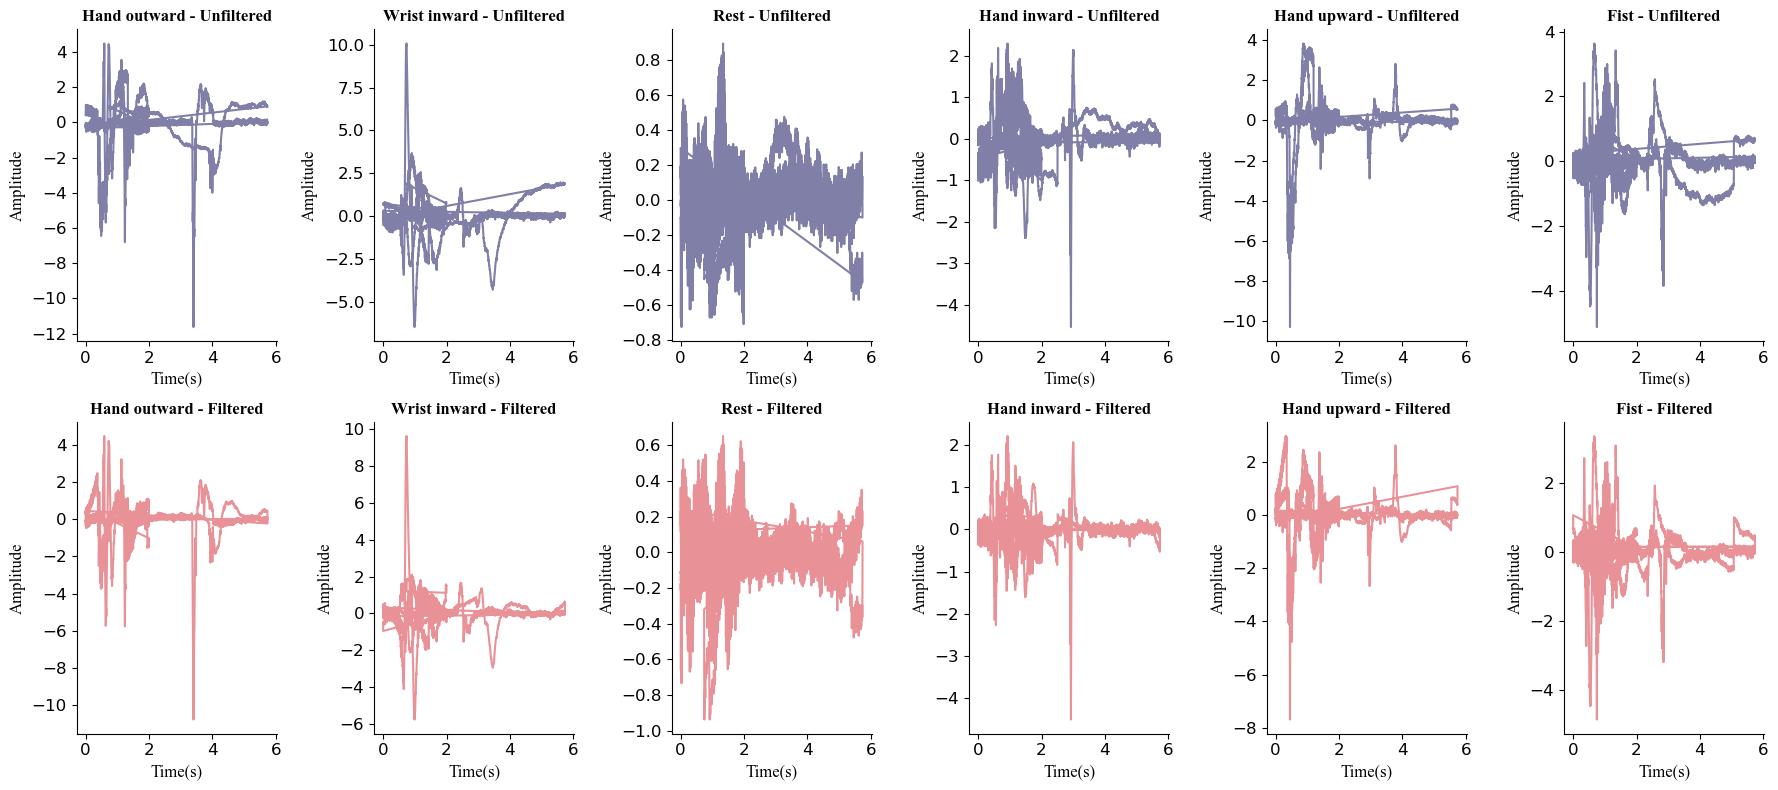

In [102]:
# Define a function to plot sEMG data
def plot_emg_data(df, title, ax, channel, color):
    
    for i, (_, group) in enumerate(df.groupby(['GestureName'])):
        ax.plot(group['Time(s)'], group[channel], color=color, alpha=0.5)
    ax.set_title(title, fontproperties=font_times_bold)
    ax.set_xlabel('Time(s)', fontproperties=font_times)
    ax.set_ylabel('Amplitude', fontproperties=font_times)
    ax.tick_params(axis='both', labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

# Set the channel to plot
channel = 'Channel 1'

# Plot the data before and after filtering
gesture_names = df_zscore['GestureName'].unique().tolist()
fig, axes = plt.subplots(nrows=2, ncols=len(gesture_names), figsize=(18, 8))

for i, gesture in enumerate(gesture_names):
    # Get the data for the participant
    gesture_unfiltered = df_zscore[(df_zscore['GestureName'] == gesture) &
                                       (df_zscore['GestureName'] == gesture)]
    gesture_filtered = df_zscore_filtered[(df_zscore_filtered['GestureName'] == gesture) &
                                     (df_zscore_filtered['GestureName'] == gesture)]

    # Plot the unfiltered data
    plot_emg_data(gesture_unfiltered, f'{gesture} - Unfiltered', axes[0, i], channel, colors[0])
    # Plot the filtered data
    plot_emg_data(gesture_filtered, f'{gesture} - Filtered', axes[1, i], 'Filtered Channel 1', colors[1])

fig.tight_layout()
print("Channel 1: Z-Score")
plt.show()

Channel 1: Hampel


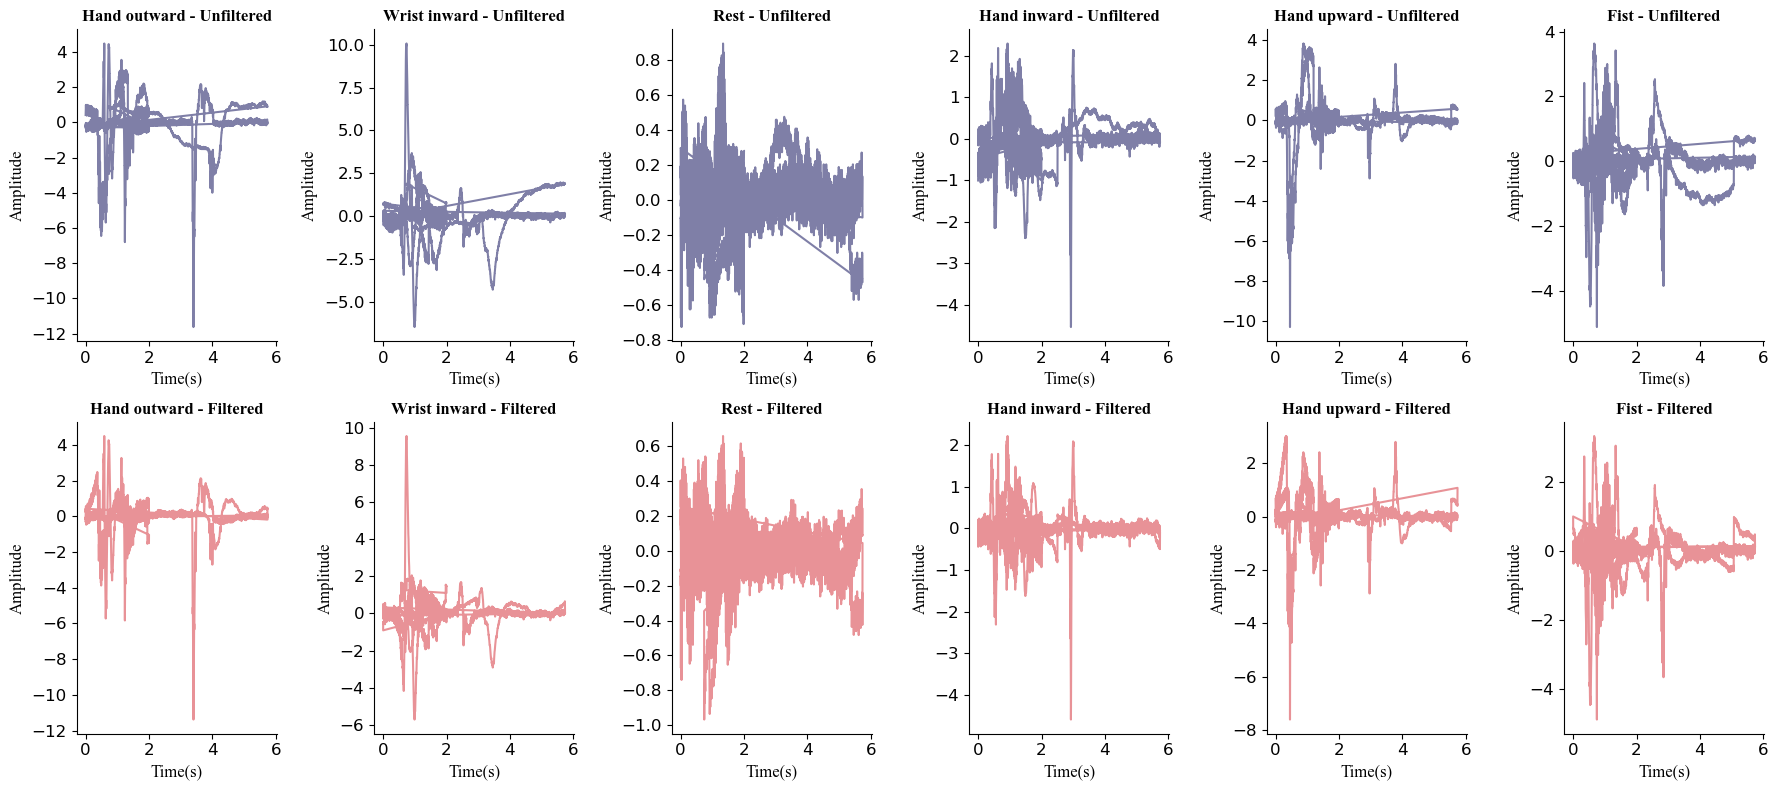

In [117]:
# Set the channel to plot
channel = 'Channel 1'

# Plot the data before and after filtering
gesture_names = df_hampel['GestureName'].unique().tolist()
fig, axes = plt.subplots(nrows=2, ncols=len(gesture_names), figsize=(18, 8))

for i, gesture in enumerate(gesture_names):
    # Get the data for the participant
    gesture_unfiltered = df_zscore[(df_hampel['GestureName'] == gesture) &
                                       (df_hampel['GestureName'] == gesture)]
    gesture_filtered = df_zscore_filtered[(df_hampel_filtered['GestureName'] == gesture) &
                                     (df_hampel_filtered['GestureName'] == gesture)]

    # Plot the unfiltered data
    plot_emg_data(gesture_unfiltered, f'{gesture} - Unfiltered', axes[0, i], channel, colors[0])
    # Plot the filtered data
    plot_emg_data(gesture_filtered, f'{gesture} - Filtered', axes[1, i], 'Filtered Channel 1', colors[1])

fig.tight_layout()
print("Channel 1: Hampel")
plt.show()

## Classification

### KNN

This section of the code evaluates the classification performance of a K-Nearest Neighbors (KNN) classifier using 10-fold cross-validation for each of the six preprocessed dataframes. The KNN classifier uses 3 neighbors.

For each preprocessed dataframe, the code drops any missing values, extracts the features and labels, and scales the features using StandardScaler. The classifier's mean accuracy and standard deviation are printed, along with the confusion matrix and classification report.

#### Z-Score

In [154]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


zknn = df_zscore_filtered.copy()
zknn = zknn.dropna()
X = zknn[['Filtered Channel 1', 'Filtered Channel 2']].values
y = zknn['GestureName'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)

# 10-fold cross validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = cross_val_score(knn, X_scaled, y, cv=cv, scoring='accuracy')

# Print mean and standard deviation of accuracy scores
print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))

# Get confusion matrix
y_pred = cross_val_predict(knn, X_scaled, y, cv=cv)
conf_matrix = confusion_matrix(y, y_pred)
print('Confusion matrix:\n', conf_matrix)

# Print classification report
print("\nClassification Report:\n", classification_report(y, y_pred))

Accuracy: 1.00 (+/- 0.00)
Confusion matrix:
 [[47803    23    20    25    77    52]
 [    9 47910     8     1    10    62]
 [  109    49 47653    25    49   115]
 [  141     9    43 47706    67    34]
 [    6     3     6     1 47957    27]
 [   33    53    12     4    73 47825]]

Classification Report:
               precision    recall  f1-score   support

        Fist       0.99      1.00      0.99     48000
 Hand inward       1.00      1.00      1.00     48000
Hand outward       1.00      0.99      1.00     48000
 Hand upward       1.00      0.99      1.00     48000
        Rest       0.99      1.00      1.00     48000
Wrist inward       0.99      1.00      1.00     48000

    accuracy                           1.00    288000
   macro avg       1.00      1.00      1.00    288000
weighted avg       1.00      1.00      1.00    288000

Precision: 1.00 (+/- 0.00)
Recall: 1.00 (+/- 0.00)
F1-score: 1.00 (+/- 0.00)


Z-Score with Seperate Test Set

In [155]:
zknn = df_zscore_filtered.copy()
zknn = zknn.dropna()
X = zknn[['Filtered Channel 1', 'Filtered Channel 2']].values
y = zknn['GestureName'].values

# Split data into 70% training set and 30% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features using training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)

# Train model using training set
knn.fit(X_train_scaled, y_train)

# Standardize test set using scaler fitted on training set
X_test_scaled = scaler.transform(X_test)

# Predict labels of test set using trained model
y_pred = knn.predict(X_test_scaled)

# Get confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', conf_matrix)

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion matrix:
 [[14373    11    10     5    35    16]
 [    0 14451     6     0     4    24]
 [   45    13 14308     2    16    42]
 [   42     4    25 14233    31     8]
 [    4     2     3     1 14246    21]
 [   18    26     1     0    29 14345]]

Classification Report:
               precision    recall  f1-score   support

        Fist       0.99      0.99      0.99     14450
 Hand inward       1.00      1.00      1.00     14485
Hand outward       1.00      0.99      0.99     14426
 Hand upward       1.00      0.99      1.00     14343
        Rest       0.99      1.00      0.99     14277
Wrist inward       0.99      0.99      0.99     14419

    accuracy                           0.99     86400
   macro avg       0.99      0.99      0.99     86400
weighted avg       0.99      0.99      0.99     86400



#### IQR

In [144]:
iqrknn = df_iqr_filtered.copy()
iqrknn = iqrknn.dropna()
X = iqrknn[['Filtered Channel 1', 'Filtered Channel 2']].values
y = iqrknn['GestureName'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)

# 10-fold cross validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = cross_val_score(knn, X_scaled, y, cv=cv, scoring='accuracy')

# Print mean and standard deviation of accuracy scores
print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))

# Get confusion matrix
y_pred = cross_val_predict(knn, X_scaled, y, cv=cv)
conf_matrix = confusion_matrix(y, y_pred)
print('Confusion matrix:\n', conf_matrix)

# Print classification report
print("\nClassification Report:\n", classification_report(y, y_pred))

Accuracy: 0.97 (+/- 0.00)
Confusion matrix:
 [[32273   326   210    23   150   248]
 [  275 34983    16    20   437   326]
 [  233    39 28054    31   256    69]
 [   43    37    44 37982    98    92]
 [  157   514   170   147 46059   488]
 [  248   382    32    59   434 25995]]

Classification Report:
               precision    recall  f1-score   support

        Fist       0.97      0.97      0.97     33230
 Hand inward       0.96      0.97      0.97     36057
Hand outward       0.98      0.98      0.98     28682
 Hand upward       0.99      0.99      0.99     38296
        Rest       0.97      0.97      0.97     47535
Wrist inward       0.96      0.96      0.96     27150

    accuracy                           0.97    210950
   macro avg       0.97      0.97      0.97    210950
weighted avg       0.97      0.97      0.97    210950



#### Hampel

In [151]:
hempelknn = df_hampel_filtered.copy()
hempelknn = hempelknn.dropna()
X = hempelknn[['Filtered Channel 1', 'Filtered Channel 2']].values
y = hempelknn['GestureName'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)

# 10-fold cross validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = cross_val_score(knn, X_scaled, y, cv=cv, scoring='accuracy')

# Print mean and standard deviation of accuracy scores
print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))

# Get confusion matrix
y_pred = cross_val_predict(knn, X_scaled, y, cv=cv)
conf_matrix = confusion_matrix(y, y_pred)
print('Confusion matrix:\n', conf_matrix)

# Print classification report
print("\nClassification Report:\n", classification_report(y, y_pred))

Accuracy: 1.00 (+/- 0.00)
Confusion matrix:
 [[47908     2    27    19    42     2]
 [    0 47986     1     2     4     7]
 [   24     8 47906    22    27    13]
 [   44     1    40 47874    34     7]
 [   55     5    22    13 47870    35]
 [    1     7     1     0     8 47983]]

Classification Report:
               precision    recall  f1-score   support

        Fist       1.00      1.00      1.00     48000
 Hand inward       1.00      1.00      1.00     48000
Hand outward       1.00      1.00      1.00     48000
 Hand upward       1.00      1.00      1.00     48000
        Rest       1.00      1.00      1.00     48000
Wrist inward       1.00      1.00      1.00     48000

    accuracy                           1.00    288000
   macro avg       1.00      1.00      1.00    288000
weighted avg       1.00      1.00      1.00    288000



### Random Forest

We previously performed grid search for random forest:
{'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}



from sklearn.model_selection import GridSearchCV

Define the parameter grid 
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf = RandomForestClassifier(random_state=42)

Initialize the GridSearchCV 
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

Fit the GridSearchCV 
grid_search.fit(X_train, y_train)

Print the best parameters found during the search
print("Best parameters found by grid search:")
print(grid_search.best_params_)

Use the best estimator
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

Calculate and print the accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(f"Tuned Random Forest accuracy: {accuracy * 100:.2f}%")

### To be continued